# Notebook to generate the plots for the paper

### Getting the data

If you do not already have the data to run this this notebook, you need to
download it from here.



### Standards modules

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import scipy
from scipy import signal
import pathlib
import itertools
import glob
import json
import seaborn as sns
from matplotlib.ticker import MaxNLocator
from matplotlib import gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable

### Custom Modules

In [3]:
sys.path.append("../scripts")

import classification_algorithms as ca
import reduced_models as rm
import task_analysis as ta

import misc
import gmac

In [4]:
# Define the font family and size
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Helvetica']
plt.rcParams['font.weight'] = 'light'  # Use 'light' font weight
plt.rcParams.update({"text.usetex": True, "font.family": "Helvetica"})


## Define notebook level constants

In [5]:
# Sampling rate for the data is 50ms
dT = 0.02
Fs = int(1 / dT)

In [6]:
# Generate all possible combinations of parameters.
def generate_param_combinations_am(param_ranges: dict) -> dict:
    """
    Generate all possible combinations of parameters.
    """
    for _fc in param_ranges["fc"]:
        for _nc in param_ranges["nc"]:
            for _nam in param_ranges["nam"]:
                yield {
                    "fc": _fc,
                    "nc": int(_nc),
                    "nam": int(_nam)
                }

## Read the Controls and Patients Data

In [7]:
# Read healthy and control data
left, right = misc.read_data(subject_type='control')
aff, unaff = misc.read_data(subject_type='patient')

# Assign segments for each subject
left = pd.concat([misc.assign_segments(left[left.subject == subj], dur_th=1, dT=dT)
                  for subj in left.subject.unique()], axis=0)
right = pd.concat([misc.assign_segments(right[right.subject == subj], dur_th=1, dT=dT)
                   for subj in right.subject.unique()])
aff = pd.concat([misc.assign_segments(aff[aff.subject == subj], dur_th=1, dT=dT)
                 for subj in aff.subject.unique()])
unaff = pd.concat([misc.assign_segments(unaff[unaff.subject == subj], dur_th=1, dT=dT)
                   for subj in unaff.subject.unique()])

# All limbs data ddf
datadf = {
    "left": left,
    "right": right,
    "aff": aff,
    "unaff": unaff
}

## Read the Pitch and Accl. Mag. Estimation files

In [8]:
basedir = "../data/output-r1-full-new"

# Read gmac parameters.
with open(pathlib.Path(basedir, "gmac", "gmac_params.json"), "r") as f:
    gmac_param_ranges = json.load(f)

In [9]:
# Read pitch, gm, and gmac performance file
gmac_perf = pd.read_csv(pathlib.Path(basedir, "gmac", "perf_gmac.csv"))

## Read Subash et 2022 results file

In [10]:
# Read data from Tanya's paper
tempdf = pd.read_csv("../data/subash22data.csv")
del tempdf["Unnamed: 0"]

# Organize data into dictionary
limbsdef = {
    "left": "left",
    "right": "right",
    "aff": "affected",
    "unaff": "unaffected"
}
subash22df = {
    lk: tempdf[tempdf.hand == lv].reset_index(drop=True)
    for lk, lv in limbsdef.items()
}

In [11]:
# # Limbs
# limbs = ["left", "right", "aff", "unaff"]
# subash_perf_gmac = {
#     "youden": [],
#     "sensitivity": [],
#     "specificity": [],
# }

# model = "GMAC"
# for i, limb in enumerate(limbs):
#     _inx = (subash22df[limb].method == model)
#     subash_perf_gmac["youden"].append(subash22df[limb][_inx]["youden"].values)
#     subash_perf_gmac["sensitivity"].append(subash22df[limb][_inx]["sensitivity"].values)
#     subash_perf_gmac["specificity"].append(subash22df[limb][_inx]["specificity"].values)

# # RF Intersubject
# subash_perf_rfinter = {
#     "youden": [],
#     "sensitivity": [],
#     "specificity": [],
# }

# model = "RF inter"
# for i, limb in enumerate(limbs):
#     _inx = (subash22df[limb].method == model)
#     subash_perf_rfinter["youden"].append(subash22df[limb][_inx]["youden"].values)
#     subash_perf_rfinter["sensitivity"].append(subash22df[limb][_inx]["sensitivity"].values)
#     subash_perf_rfinter["specificity"].append(subash22df[limb][_inx]["specificity"].values)

# # RF Intrasubject
# subash_perf_rfintra = {
#     "youden": [],
#     "sensitivity": [],
#     "specificity": [],
# }

# model = "RF intra"
# for i, limb in enumerate(limbs):
#     _inx = (subash22df[limb].method == model)
#     subash_perf_rfintra["youden"].append(subash22df[limb][_inx]["youden"].values)
#     subash_perf_rfintra["sensitivity"].append(subash22df[limb][_inx]["sensitivity"].values)
#     subash_perf_rfintra["specificity"].append(subash22df[limb][_inx]["specificity"].values)

# # RF Intrasubject mean
# subash_perf_rfintra_mean = {
#     "youden": [],
#     "sensitivity": [],
#     "specificity": [],
# }

# model = "RF intra"
# for i, limb in enumerate(limbs):
#     _inx = (subash22df[limb].method == model)
#     subash_perf_rfintra_mean["youden"].append(subash22df[limb][_inx].groupby("subject")["youden"].mean().values)
#     subash_perf_rfintra_mean["sensitivity"].append(subash22df[limb][_inx].groupby("subject")["youden"].mean().values)
#     subash_perf_rfintra_mean["specificity"].append(subash22df[limb][_inx].groupby("subject")["youden"].mean().values)

## GMAC Performance: Inter-Subject without validation

In [11]:
# Number of all possible combinations
Ncombs = len(list(misc.generate_param_combinations_gmac(gmac_param_ranges)))

# All parameter combinations.
param_combs_enum = list(misc.generate_param_combinations_gmac_wenum(gmac_param_ranges))

In [12]:
# Generate data for heatmap
# Get performance for the different parameters combinations.
_keys = ["np", "fc", "nc", "nam", "p_th", "p_th_band", "am_th", "am_th_band"]
lens = [len(gmac_param_ranges[_k]) for _k in _keys]
perf = np.zeros(lens)
med = np.zeros(lens)
iqr = np.zeros(lens)
limbs = ["left", "right", "aff", "unaff"]
for i, pcvalenum in enumerate(param_combs_enum):
    _ix, _pcval = pcvalenum
    # Go through all limbs
    _vals = []
    # for l, _lmb in enumerate(limbs):
    _inx = ((gmac_perf.np == _pcval["np"]) &
            (gmac_perf.fc == _pcval["fc"]) &
            (gmac_perf.nc == _pcval["nc"]) &
            (gmac_perf.nam == _pcval["nam"]) &
            (gmac_perf.am_th == _pcval["am_th"]) &
            (gmac_perf.am_th_band == _pcval["am_th_band"]) &
            (gmac_perf.p_th == _pcval["p_th"]) &
            (gmac_perf.p_th_band == _pcval["p_th_band"]))
    _vals.append(gmac_perf.loc[_inx, "youden"].values)
    _ixstr = [f"{k}: {v:2d}" for k, v in _ix.items()]
    sys.stdout.write(f"\r{i:5d} {', '.join(_ixstr)}")
    sys.stdout.flush()
    # Compute the cost.
    _vals = np.hstack(_vals)
    # Computer performance
    _perfs = [np.percentile(_vals, q) for q in [25, 50, 75]]
    _i = tuple(_ix[_k] for _k in _keys)
    perf[_i] = _perfs[1] * (1 - (_perfs[2] - _perfs[0]))
    med[_i] = _perfs[1]
    iqr[_i] = _perfs[2] - _perfs[0]

# Save the perf data as a numpy file
np.save(pathlib.Path(basedir, "all_perf.npy"), perf)

    1 np:  0, fc:  0, nc:  0, nam:  0, p_th:  0, p_th_band:  0, am_th:  1, am_th_band:  0

10259 np:  2, fc:  1, nc:  1, nam:  2, p_th: 18, p_th_band:  4, am_th:  2, am_th_band:  0

In [13]:
# Maximum performance
# ["np", "fc", "nc", "nam", "p_th", "p_th_band", "am_th", "am_th_band"]
_perf = perf[:, :, :, :, :, :, :, :]
maxperf = np.max(_perf)
maxinx = np.where(_perf == maxperf)
bestarg = [
    gmac_param_ranges["np"][maxinx[0][0]],
    gmac_param_ranges["fc"][maxinx[1][0]],
    gmac_param_ranges["nc"][maxinx[2][0]],
    gmac_param_ranges["nam"][maxinx[3][0]],
    gmac_param_ranges["p_th"][:][maxinx[4][0]],
    gmac_param_ranges["p_th_band"][maxinx[5][0]],
    gmac_param_ranges["am_th"][maxinx[6][0]],
    gmac_param_ranges["am_th_band"][maxinx[7][0]]
]
bestarg

[50, 0.01, 2, 50, 10, 40, 0.1, 0]

In [14]:
print("Perf: ", np.min(perf), np.max(perf))

Perf:  0.0 0.409127608200469


In [15]:
# How different is the maximum?
_perf = perf[:, :, :, :, :, :, :, :]
# Maximum performance
maxperf = np.max(_perf)
minperf = np.min(_perf)
_inx = (100 * (_perf - minperf) / (maxperf - minperf)) > 95
perfinx = np.where(_inx)
topperf = _perf[perfinx]
topperfparam = np.array([
    [
        gmac_param_ranges["np"][perfinx[0][i]],
        gmac_param_ranges["fc"][perfinx[1][i]],
        gmac_param_ranges["nc"][perfinx[2][i]],
        gmac_param_ranges["nam"][perfinx[3][i]],
        gmac_param_ranges["p_th"][:][perfinx[4][i]],
        gmac_param_ranges["p_th_band"][perfinx[5][i]],
        gmac_param_ranges["am_th"][perfinx[6][i]],
        gmac_param_ranges["am_th_band"][perfinx[7][i]],
        topperf[i]
    ]
    for i in range(len(perfinx[0]))
])
# Sort by performance
_inxpersort = np.argsort(topperf)[::-1]
topperfparam = topperfparam[_inxpersort, :]
perfinxsort = np.array(perfinx).T[_inxpersort, :]
np.set_printoptions(precision=4, suppress=True)
print(topperfparam)

[[50.      0.01    2.     50.     10.     40.      0.1     0.      0.4091]
 [50.      0.01    2.     25.     10.     40.      0.1     0.      0.4087]
 [25.      0.01    2.     50.     20.     60.      0.1     0.      0.4056]
 [50.      0.1     2.     25.     10.     40.      0.1     0.      0.402 ]
 [25.      0.01    2.     25.     20.     60.      0.1     0.      0.4015]
 [50.      0.01    2.      1.     10.     40.      0.1     0.      0.3998]
 [50.      0.1     2.     50.     10.     40.      0.1     0.      0.3979]
 [25.      0.01    1.     25.     20.     60.      0.1     0.      0.397 ]
 [25.      0.01    1.     50.     20.     60.      0.1     0.      0.3955]
 [50.      0.01    1.     25.     10.     40.      0.1     0.      0.3954]
 [50.      0.01    1.     50.     10.     40.      0.1     0.      0.3933]
 [25.      0.01    2.      1.     20.     60.      0.1     0.      0.3911]
 [50.      0.1     1.      1.     10.     40.      0.1     0.      0.3911]
 [50.      0.01    2.    

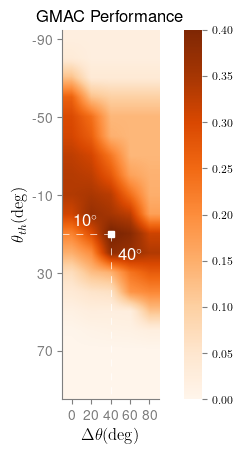

In [16]:
fig = plt.figure()
maxinx = perfinxsort[0]

ax = fig.add_subplot(1, 1, 1)
# Create the heatmap using imshow
_hm = ax.imshow(_perf[perfinxsort[0, 0],
                      perfinxsort[0, 1],
                      perfinxsort[0, 2],
                      perfinxsort[0, 3],
                      :, :,
                      perfinxsort[0, 6],
                      perfinxsort[0, 7]], cmap='Oranges', interpolation='bilinear',
                vmin=0, vmax=0.4)

ax.set_ylabel(r'$\theta_{th} (\deg)$', fontsize=12)
ax.set_yticks(np.arange(len(gmac_param_ranges["p_th"])),
              labels=gmac_param_ranges["p_th"],
              color="tab:gray")
ax.yaxis.set_major_locator(MaxNLocator(integer=True, nbins=5))
ax.spines["left"].set_visible(True)
ax.spines["left"].set_color("tab:gray")
ax.yaxis.set_tick_params(color='tab:grey')
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["bottom"].set_color("tab:gray")

# Set x ticks
ax.set_xticks(np.arange(len(gmac_param_ranges["p_th_band"])),
                labels=gmac_param_ranges["p_th_band"],
                color="tab:gray")

# Add labels to the axes
ax.set_xlabel(r'$\Delta\theta (\deg)$', fontsize=12)
ax.xaxis.set_tick_params(color='tab:grey')

# # Plot the max. point.
ax.plot(maxinx[5], maxinx[4], 's', color='white', markersize=5)
ax.plot([maxinx[5], maxinx[5]],
        [maxinx[4], len(gmac_param_ranges["p_th"]) - 0.5], lw=0.5,
        linestyle='dashed', dashes=(10, 10),
        color='white')
ax.plot([-0.5, maxinx[5]],
        [maxinx[4], maxinx[4]], lw=0.5,
        linestyle='dashed', dashes=(10, 10),
        color='white')
# Show the max. argument
ax.text(maxinx[5] - 1.25, maxinx[4] - 0.25,
        (f"{bestarg[4]:0.0f}" + r"$^\circ$"),
        color='white', ha='center', va='bottom',
        fontsize=12)
ax.text(maxinx[5] + 1, maxinx[4] + 1.5,
        (f"{bestarg[5]:0.0f}" + r"$^\circ$"),
        color='white', ha='center', va='bottom',
        fontsize=12)

# Color map
_cbar = plt.colorbar(_hm)
# Modify colorbar settings
_cbar.ax.tick_params(labelsize=8)  # Set tick label font size
_cbar.set_alpha(0.7)  # Set colorbar opacity (alpha value)
_cbar.outline.set_linewidth(0.)  # Set the colorbar outline thickness
_cbar.ax.yaxis.set_tick_params(color='tab:gray')

ax.set_title("GMAC Performance")

plt.subplots_adjust(wspace=-0.2)

# Save plot
fig.savefig(pathlib.Path(basedir, "gmac_perf_hm.pdf"), bbox_inches="tight")
fig.savefig(pathlib.Path(basedir, "gmac_perf_hm.svg"), bbox_inches="tight")

## Extra plots

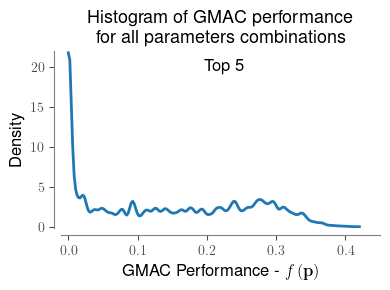

In [17]:
# All possible Younden index, Sensitivity, and Specificity
fig = plt.figure(figsize=(4, 3))

# Histrogram of all Younden indices
ax = fig.add_subplot(111)
sns.kdeplot(data=perf.flatten(), bw_adjust=0.2, clip=[0, 1], lw=2, ax=ax)
ax.set_xlim(-0.01, 0.45)
ax.set_ylim(-0.2, 22)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_position(('outward', 5))
ax.spines['bottom'].set_position(('outward', 5))
ax.spines['left'].set_color("tab:gray")
ax.spines['bottom'].set_color("tab:gray")
ax.tick_params(axis='x', colors='0.3')
ax.tick_params(axis='y', colors='0.3')
ax.set_ylabel("Density", fontsize=12)
ax.set_xlabel(r"GMAC Performance - $f\left(\mathbf{p}\right)$", fontsize=12)
ax.set_title("Histogram of GMAC performance\nfor all parameters combinations", fontsize=13)

# Display the range details of the performance measure.
ax.text(0.225, 20,
        "\n".join((f"Top 5% range: {topperfparam[-1, -1]:0.3f}-{topperfparam[0, -1]:0.3f}",)),
        color='black', ha='center', va='center', fontsize=12)

plt.tight_layout()

# Save plot
fig.savefig(pathlib.Path(basedir, "all_gmacperf_hist.pdf"), bbox_inches="tight")
fig.savefig(pathlib.Path(basedir, "all_gmacperf_hist.svg"), bbox_inches="tight")

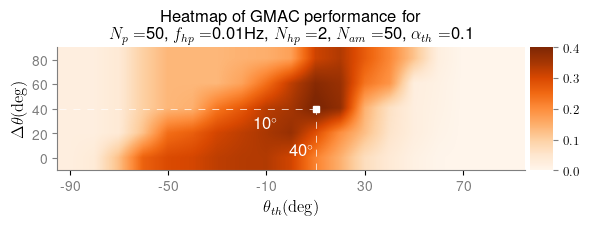

In [18]:
maxinx = perfinxsort[0]

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
# Create the heatmap using imshow
_hm = ax.imshow(_perf[perfinxsort[0, 0],
                      perfinxsort[0, 1],
                      perfinxsort[0, 2],
                      perfinxsort[0, 3],
                      :, ::-1,
                      perfinxsort[0, 6],
                      perfinxsort[0, 7]].T, cmap='Oranges', interpolation='bilinear',
                vmin=0, vmax=0.4)

ax.set_xlabel(r'$\theta_{th} (\deg)$', fontsize=12)
ax.set_xticks(np.arange(len(gmac_param_ranges["p_th"])),
              labels=gmac_param_ranges["p_th"],
              color="tab:gray")
ax.xaxis.set_major_locator(MaxNLocator(integer=True, nbins=5))
ax.spines["left"].set_visible(True)
ax.spines["left"].set_color("tab:gray")
ax.yaxis.set_tick_params(color='tab:grey')
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["bottom"].set_color("tab:gray")

# Set y ticks
ax.set_yticks(np.arange(len(gmac_param_ranges["p_th_band"])),
              labels=gmac_param_ranges["p_th_band"][::-1],
              color="tab:gray")

# Add labels to the axes
ax.set_ylabel(r'$\Delta\theta (\deg)$', fontsize=12)
ax.yaxis.set_tick_params(color='tab:grey')

# Plot the max. point.
ax.plot(maxinx[4], maxinx[5], 's', color='white', markersize=5)
ax.plot([maxinx[4], -0.5],
        [maxinx[5], maxinx[5]], lw=0.5,
        linestyle='dashed', dashes=(10, 10),
        color='white')
ax.plot([maxinx[4], maxinx[4]],
        [len(gmac_param_ranges["p_th_band"]) - 0.5, maxinx[5]],
        lw=0.5,
        linestyle='dashed', dashes=(10, 10),
        color='white')
# Show the max. argument
ax.text(maxinx[4] - 2.0, maxinx[5] + 0.9,
        (f"{bestarg[4]:0.0f}" + r"$^\circ$"),
        color='white', ha='center', va='bottom',
        fontsize=12)
ax.text(maxinx[4] - 0.6, maxinx[5] + 2.0,
        (f"{bestarg[5]:0.0f}" + r"$^\circ$"),
        color='white', ha='center', va='bottom',
        fontsize=12)

# Color map
# create an axes on the right side of ax. The width of cax will be 5%
# of ax and the padding between cax and ax will be fixed at 0.05 inch.
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
_cbar = plt.colorbar(_hm, cax=cax)
# Modify colorbar settings
_cbar.ax.tick_params(labelsize=9)  # Set tick label font size
_cbar.set_alpha(0.7)  # Set colorbar opacity (alpha value)
_cbar.outline.set_linewidth(0.)  # Set the colorbar outline thickness
_cbar.ax.yaxis.set_tick_params(color='tab:gray')
_str = ("Heatmap of GMAC performance for\n" + 
        ", ".join((r"$N_p=$" + f"{int(topperfparam[0, 0])}",
                   r"$f_{hp}=$" + f"{topperfparam[0, 1]}Hz",
                   r"$N_{hp}= $" + f"{int(topperfparam[0, 2])}",
                   r"$N_{am}= $" + f"{int(topperfparam[0, 3])}",
                   r"$\alpha_{th}=$" + f"{topperfparam[0, 6]:}")))
ax.set_title(_str, fontsize=12)

# Save plot
fig.savefig(pathlib.Path(basedir, "gmac_perf_hm.pdf"), bbox_inches="tight")
fig.savefig(pathlib.Path(basedir, "gmac_perf_hm.svg"), bbox_inches="tight")


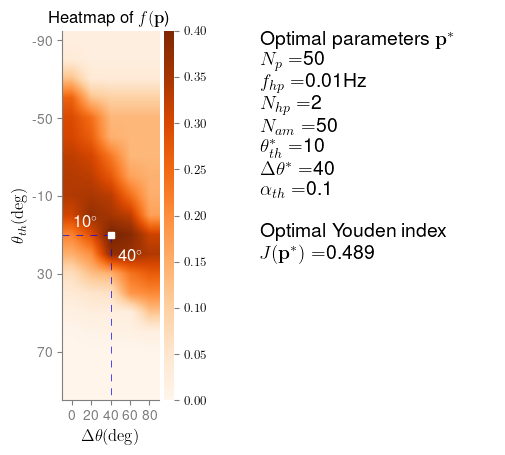

In [19]:
fig = plt.figure()
maxinx = perfinxsort[0]

ax = fig.add_subplot(1, 2, 1)
# Create the heatmap using imshow
_hm = ax.imshow(_perf[perfinxsort[0, 0],
                      perfinxsort[0, 1],
                      perfinxsort[0, 2],
                      perfinxsort[0, 3],
                      :, :,
                      perfinxsort[0, 6],
                      perfinxsort[0, 7]], cmap='Oranges', interpolation='bilinear',
                vmin=0, vmax=0.4)

ax.set_ylabel(r'$\theta_{th} (\deg)$', fontsize=12)
ax.set_yticks(np.arange(len(gmac_param_ranges["p_th"])),
              labels=gmac_param_ranges["p_th"],
              color="tab:gray")
ax.yaxis.set_major_locator(MaxNLocator(integer=True, nbins=5))
ax.spines["left"].set_visible(True)
ax.spines["left"].set_color("tab:gray")
ax.yaxis.set_tick_params(color='tab:grey')
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["bottom"].set_color("tab:gray")

# Set x ticks
ax.set_xticks(np.arange(len(gmac_param_ranges["p_th_band"])),
                labels=gmac_param_ranges["p_th_band"],
                color="tab:gray")

# Add labels to the axes
ax.set_xlabel(r'$\Delta\theta (\deg)$', fontsize=12)
ax.xaxis.set_tick_params(color='tab:grey')

# # Plot the max. point.
ax.plot([maxinx[5], maxinx[5]],
        [maxinx[4], len(gmac_param_ranges["p_th"]) - 0.5], lw=0.5,
        linestyle='dashed', dashes=(10, 10),
        color='blue')
ax.plot([-0.5, maxinx[5]],
        [maxinx[4], maxinx[4]], lw=0.5,
        linestyle='dashed', dashes=(10, 10),
        color='blue')
ax.plot(maxinx[5], maxinx[4], 's', color='white', markersize=5)
# Show the max. argument
ax.text(maxinx[5] - 1.25, maxinx[4] - 0.25,
        (f"{bestarg[4]:0.0f}" + r"$^\circ$"),
        color='white', ha='center', va='bottom',
        fontsize=12)
ax.text(maxinx[5] + 1, maxinx[4] + 1.5,
        (f"{bestarg[5]:0.0f}" + r"$^\circ$"),
        color='white', ha='center', va='bottom',
        fontsize=12)

# Color map
# create an axes on the right side of ax. The width of cax will be 5%
# of ax and the padding between cax and ax will be fixed at 0.05 inch.
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="10%", pad=0.05)
_cbar = plt.colorbar(_hm, cax=cax)
# Modify colorbar settings
_cbar.ax.tick_params(labelsize=9)  # Set tick label font size
_cbar.set_alpha(0.7)  # Set colorbar opacity (alpha value)
_cbar.outline.set_linewidth(0.)  # Set the colorbar outline thickness
_cbar.ax.yaxis.set_tick_params(color='tab:gray')

_str = r"Heatmap of $f(\mathbf{p}$)"
                #   r"$N_p=f_s$, $f_{hp}=0.01Hz$, $N_{hp}=4$, $N_{am}=f_s/2$, $\alpha_{th}=0.1$"))
ax.set_title(_str, fontsize=12)

ax = fig.add_subplot(1, 2, 2)
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
# Remove frame
ax.spines["left"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["bottom"].set_visible(False)
# Remove x and y ticks
ax.set_xticks([])
ax.set_yticks([])
_jmax = med[perfinxsort[0, 0],
            perfinxsort[0, 1],
            perfinxsort[0, 2],
            perfinxsort[0, 3],
            perfinxsort[0, 4],
            perfinxsort[0, 5],
            perfinxsort[0, 6],
            perfinxsort[0, 7]]
ax.text(0.0, 1.0, 
        "\n".join((r"Optimal parameters $\mathbf{p}^*$",
                   r"$N_p=$" + f"{int(topperfparam[0, 0])}",
                   r"$f_{hp}=$" + f"{topperfparam[0, 1]}Hz",
                   r"$N_{hp}= $" + f"{int(topperfparam[0, 2])}",
                   r"$N_{am}= $" + f"{int(topperfparam[0, 3])}",
                   r"$\theta_{th}^*=$" + f"{int(topperfparam[0, 4])}",
                   r"$\Delta\theta^*=$" + f"{int(topperfparam[0, 5])}",
                   r"$\alpha_{th}=$" + f"{topperfparam[0, 6]:}"
                   "",
                   "",
                   r"Optimal Youden index",
                   r"$J(\mathbf{p}^*) = $" + f"{_jmax:0.3f}")),
        fontsize=14, ha='left', va='top')

plt.subplots_adjust(wspace=0.1)

# Save plot
fig.savefig(pathlib.Path(basedir, "gmac_perf_hm_vert.pdf"), bbox_inches="tight")
fig.savefig(pathlib.Path(basedir, "gmac_perf_hm_vert.svg"), bbox_inches="tight")

# All Subject Inter-subject GMAC Model with validation (Leave-One-Subject)

In [20]:
# Add a healthy / stroke subject column
_subjtype = [
    f"H{_row[1]['subject']}" if _row[1]["limb"] in ["left", "right"]
    else f"S{_row[1]['subject']}"
    for i, _row in enumerate(gmac_perf[["subject", "limb"]].iterrows())
]
gmac_perf["subjtype"] = _subjtype
gmac_perf

,subject,np,fc,nc,nam,p_th,p_th_band,am_th,am_th_band,limb,...,FN,TP,TNr,FPr,FNr,TPr,sensitivity,specificity,youden,subjtype
0,2,1,0.01,1,1,-90,0,0.00,0,left,...,0,17133,0.000082,0.293752,0.000000,0.706166,1.000000,0.000281,0.000281,H2
1,2,1,0.01,1,1,-90,0,0.10,0,left,...,2291,14842,0.025142,0.268692,0.094427,0.611739,0.866281,0.085566,-0.048153,H2
2,2,1,0.01,1,1,-90,0,0.25,0,left,...,6797,10336,0.130904,0.162930,0.280150,0.426016,0.603280,0.445504,0.048784,H2
3,2,1,0.01,1,1,-90,20,0.00,0,left,...,0,17133,0.000082,0.293752,0.000000,0.706166,1.000000,0.000281,0.000281,H2
4,2,1,0.01,1,1,-90,20,0.10,0,left,...,2291,14842,0.025142,0.268692,0.094427,0.611739,0.866281,0.085566,-0.048153,H2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307795,5,50,0.10,2,50,90,60,0.10,0,unaff,...,15134,0,0.381301,0.000000,0.618699,0.000000,0.000000,1.000000,0.000000,S5
307796,5,50,0.10,2,50,90,60,0.25,0,unaff,...,15134,0,0.381301,0.000000,0.618699,0.000000,0.000000,1.000000,0.000000,S5
307797,5,50,0.10,2,50,90,80,0.00,0,unaff,...,15134,0,0.381301,0.000000,0.618699,0.000000,0.000000,1.000000,0.000000,S5
307798,5,50,0.10,2,50,90,80,0.10,0,unaff,...,15134,0,0.381301,0.000000,0.618699,0.000000,0.000000,1.000000,0.000000,S5


In [21]:
# Indices for the different parameter combinations
param_combs_enum = list(misc.generate_param_combinations_gmac_wenum(gmac_param_ranges))
pcinx = [
    ((gmac_perf.np == _pcval["np"]) &
     (gmac_perf.fc == _pcval["fc"]) &
     (gmac_perf.nc == _pcval["nc"]) &
     (gmac_perf.nam == _pcval["nam"]) &
     (gmac_perf.am_th == _pcval["am_th"]) &
     (gmac_perf.am_th_band == _pcval["am_th_band"]) &
     (gmac_perf.p_th == _pcval["p_th"]) &
     (gmac_perf.p_th_band == _pcval["p_th_band"]))
    for j, (_ix, _pcval) in enumerate(param_combs_enum)
]

In [22]:
# Leave-one-out validation
subjs = list(set(gmac_perf.subjtype))

# Get performance for the different parameters combinations.
_keys = ["np", "fc", "nc", "nam", "p_th", "p_th_band", "am_th", "am_th_band"]
lens = [len(subjs)] + [len(gmac_param_ranges[_k]) for _k in _keys]
perf_loso = np.zeros(lens)
med = np.zeros(lens)
iqr = np.zeros(lens)

# All parameter combinations.
for l, _subj in enumerate(subjs):
    # Index to leave out.
    _losoinx = ~(gmac_perf.subjtype == _subj)
    # Generate data for heatmap
    for i, pcvalenum in enumerate(param_combs_enum):
        _ix, _pcval = pcvalenum
        # Go through all limbs
        _vals = gmac_perf.loc[_losoinx & pcinx[i], "youden"].values
        _ixstr = [f"{k}: {v:2d}" for k, v in _ix.items()]
        sys.stdout.write(f"\r{l:2d} {i:5d} {', '.join(_ixstr)}")
        sys.stdout.flush()
        # Compute the cost.
        # Compute performance.
        _perfs = [np.percentile(_vals, q) for q in [25, 50, 75]]
        _i = tuple([l]) + tuple(_ix[_k] for _k in _keys)
        perf_loso[_i] = _perfs[1] * (1 - (_perfs[2] - _perfs[0]))
        med[_i] = _perfs[1]
        iqr[_i] = _perfs[2] - _perfs[0]

14 10259 np:  2, fc:  1, nc:  1, nam:  2, p_th: 18, p_th_band:  4, am_th:  2, am_th_band:  0

In [44]:
# # Leave-one-out validation
# subjs = list(set(gmac_perf.subjtype))

# # Get performance for the different parameters combinations.
# _keys = ["np", "fc", "nc", "nam", "p_th", "p_th_band", "am_th", "am_th_band"]
# lens = [len(subjs)] + [len(gmac_param_ranges[_k]) for _k in _keys]
# perf_loso = np.zeros(lens)
# med = np.zeros(lens)
# iqr = np.zeros(lens)

# # All parameter combinations.
# param_combs_enum = list(misc.generate_param_combinations_gmac_wenum(gmac_param_ranges))
# for l, _subj in enumerate(subjs):
#     # Index to leave out.
#     _losoinx = ~(gmac_perf.subjtype == _subj)
#     # Generate data for heatmap
#     for i, pcvalenum in enumerate(param_combs_enum):
#         _ix, _pcval = pcvalenum
#         # Go through all limbs
#         _inx = ((gmac_perf.np == _pcval["np"]) &
#                 (gmac_perf.fc == _pcval["fc"]) &
#                 (gmac_perf.nc == _pcval["nc"]) &
#                 (gmac_perf.nam == _pcval["nam"]) &
#                 (gmac_perf.am_th == _pcval["am_th"]) &
#                 (gmac_perf.am_th_band == _pcval["am_th_band"]) &
#                 (gmac_perf.p_th == _pcval["p_th"]) &
#                 (gmac_perf.p_th_band == _pcval["p_th_band"]))
#         _vals = gmac_perf.loc[_losoinx & _inx, "youden"].values
#         _ixstr = [f"{k}: {v:2d}" for k, v in _ix.items()]
#         sys.stdout.write(f"\r{l:2d} {i:5d} {', '.join(_ixstr)}")
#         sys.stdout.flush()
#         # Compute the cost.
#         # Compute performance.
#         _perfs = [np.percentile(_vals, q) for q in [25, 50, 75]]
#         _i = tuple([l]) + tuple(_ix[_k] for _k in _keys)
#         perf_loso[_i] = _perfs[1] * (1 - (_perfs[2] - _perfs[0]))
#         med[_i] = _perfs[1]
#         iqr[_i] = _perfs[2] - _perfs[0]

# # Save the perf data as a numpy file
# np.save(pathlib.Path(basedir, f"all_perf_loso.npy"), perf_loso)

14 10259 np:  2, fc:  1, nc:  1, nam:  2, p_th: 18, p_th_band:  4, am_th:  2, am_th_band:  0

In [23]:
# perf_loso = np.load(pathlib.Path(basedir, f"all_perf_loso.npy"))
maxinx = {subjs[i]: np.array(np.where(_perf == np.max(_perf))).T[0]
          for i, _perf in enumerate(perf_loso)}
bestargs = {
    _s: [
        gmac_param_ranges["np"][_mx[0]],
        gmac_param_ranges["fc"][_mx[1]],
        gmac_param_ranges["nc"][_mx[2]],
        gmac_param_ranges["nam"][_mx[3]],
        gmac_param_ranges["p_th"][_mx[4]],
        gmac_param_ranges["p_th_band"][_mx[5]],
        gmac_param_ranges["am_th"][_mx[6]],
        gmac_param_ranges["am_th_band"][_mx[7]]
    ] for _s, _mx in maxinx.items()
}
bestargs

{'H9': [50, 0.01, 2, 25, 10, 40, 0.1, 0],
 'H10': [25, 0.1, 2, 25, 10, 40, 0.1, 0],
 'H2': [25, 0.01, 1, 25, 20, 60, 0.1, 0],
 'S4': [50, 0.01, 2, 50, 10, 40, 0.1, 0],
 'H8': [50, 0.1, 2, 25, 10, 40, 0.1, 0],
 'H6': [25, 0.1, 2, 25, 20, 60, 0.1, 0],
 'S2': [50, 0.01, 2, 25, 10, 40, 0.1, 0],
 'H7': [50, 0.01, 2, 50, 10, 40, 0.1, 0],
 'H1': [50, 0.01, 2, 25, 10, 40, 0.1, 0],
 'H4': [50, 0.01, 2, 25, 10, 40, 0.1, 0],
 'H3': [50, 0.01, 2, 25, 10, 40, 0.1, 0],
 'S5': [50, 0.01, 2, 25, 10, 40, 0.1, 0],
 'S1': [50, 0.01, 2, 50, 10, 40, 0.1, 0],
 'S3': [50, 0.01, 2, 50, 10, 40, 0.1, 0],
 'H5': [50, 0.1, 2, 25, 10, 40, 0.1, 0]}

In [24]:
# # perf_loso = np.load(pathlib.Path(basedir, f"all_perf_loso.npy"))
# maxinx = np.array([np.where(_perf == np.max(_perf)) for _perf in perf_loso]).T[0].T
# bestargs = [
#     [
#         gmac_param_ranges["np"][_mx[0]],
#         gmac_param_ranges["fc"][_mx[1]],
#         gmac_param_ranges["nc"][_mx[2]],
#         gmac_param_ranges["nam"][_mx[3]],
#         gmac_param_ranges["p_th"][_mx[4]],
#         gmac_param_ranges["p_th_band"][_mx[5]],
#         gmac_param_ranges["am_th"][_mx[6]],
#         gmac_param_ranges["am_th_band"][_mx[7]]
#     ] for _mx in maxinx
# ]
# bestargs

In [25]:
cols = ["subj", "subjid", "limb", "method",
        "youden", "sensitivity", "specificity"]
losoperfdf = pd.DataFrame(columns=cols)

# Go through each limb
for _subj in subjs:
    _losoinx = (gmac_perf.subjtype == _subj)
    sys.stdout.write(f">{_subj}")
    for _lmb in gmac_perf[_losoinx].limb.unique():
        sys.stdout.write(f" {_lmb}")
        sys.stdout.flush()
        _limbinx = (gmac_perf.limb == _lmb)
        _inx = ((gmac_perf.np == bestargs[_subj][0]) &
                (gmac_perf.fc == bestargs[_subj][1]) &
                (gmac_perf.nc == bestargs[_subj][2]) &
                (gmac_perf.nam == bestargs[_subj][3]) &
                (gmac_perf.p_th == bestargs[_subj][4]) &
                (gmac_perf.p_th_band == bestargs[_subj][5]) &
                (gmac_perf.am_th == bestargs[_subj][6]) &
                (gmac_perf.am_th_band == bestargs[_subj][7]))
        # New row df
        _newrowdf = pd.DataFrame.from_dict({
            "subj": [_subj],
            "limb": [_lmb],
            "subjid": gmac_perf[_losoinx].subject.unique(),
            "method": ["GMAC"],
            "youden": gmac_perf[_losoinx & _limbinx & _inx].youden,
            "sensitivity": gmac_perf[_losoinx & _limbinx & _inx].sensitivity,
            "specificity": gmac_perf[_losoinx & _limbinx & _inx].specificity
        })
        losoperfdf = pd.concat([losoperfdf, _newrowdf], ignore_index=True)
    sys.stdout.write("\n")
losoperfdf

>H9 left right
>H10 left right
>H2 left right
>S4 aff unaff
>H8 left right
>H6 left right
>S2 aff unaff
>H7 left right
>H1 left right
>H4 left right
>H3 left right
>S5 aff unaff
>S1 aff unaff
>S3 aff unaff
>H5 left right


,subj,subjid,limb,method,youden,sensitivity,specificity
0,H9,9,left,GMAC,0.764873,0.872587,0.892287
1,H9,9,right,GMAC,0.884187,0.929606,0.954581
2,H10,10,left,GMAC,0.323321,0.642773,0.680548
3,H10,10,right,GMAC,0.444087,0.759789,0.684298
4,H2,2,left,GMAC,0.268546,0.866807,0.401739
5,H2,2,right,GMAC,0.405791,0.959381,0.446410
6,S4,4,aff,GMAC,0.545639,0.949324,0.596315
7,S4,4,unaff,GMAC,0.464514,0.922351,0.542164
8,H8,8,left,GMAC,0.410198,0.621266,0.788932
9,H8,8,right,GMAC,0.592651,0.816994,0.775657


In [39]:
# subjs = list(set(gmac_perf.subjtype))

# # Get the performance of the left out subject for the best parameters.
# losoperf = {
#     "youden": np.zeros(2 * len(subjs)),
#     "sensitivity": np.zeros(2 * len(subjs)),
#     "specificity": np.zeros(2 * len(subjs)),
# }
# # for i, (_lmb, _subj) in enumerate(subjs):
# for i, _subj in enumerate(subjs):
#     # Index to leave out.
#     _looinx = (gmac_perf.subjtype == _subj)
#     _inx = ((gmac_perf.np == bestargs[i][0]) &
#             (gmac_perf.fc == bestargs[i][1]) &
#             (gmac_perf.nc == bestargs[i][2]) &
#             (gmac_perf.nam == bestargs[i][3]) &
#             (gmac_perf.p_th == bestargs[i][4]) &
#             (gmac_perf.p_th_band == bestargs[i][5]) &
#             (gmac_perf.am_th == bestargs[i][6]) &
#             (gmac_perf.am_th_band == bestargs[i][7]))
#     # Computer performance
#     losoperf["youden"][2 * i] = gmac_perf.loc[_looinx & _inx, "youden"].values[0]
#     losoperf["youden"][2 * i + 1] = gmac_perf.loc[_looinx & _inx, "youden"].values[1]
#     losoperf["sensitivity"][2 * i] = gmac_perf.loc[_looinx & _inx, "sensitivity"].values[0]
#     losoperf["sensitivity"][2 * i + 1] = gmac_perf.loc[_looinx & _inx, "sensitivity"].values[1]
#     losoperf["specificity"][2 * i] = gmac_perf.loc[_looinx & _inx, "specificity"].values[0]
#     losoperf["specificity"][2 * i + 1] = gmac_perf.loc[_looinx & _inx, "specificity"].values[1]

### Now add results from Subash et al. 2022

In [26]:
# Go through each limb
for _subj in subjs:
    _losoinx = (gmac_perf.subjtype == _subj)
    sys.stdout.write(f">{_lmb}")
    for _lmb in gmac_perf[_losoinx].limb.unique():
        sys.stdout.write(f" {_subj}")
        sys.stdout.flush()
        _subjid = gmac_perf[gmac_perf.subjtype == _subj]["subject"].unique()[0]
        #
        # # Old GMAC
        _minx = subash22df[_lmb].method == "GMAC"
        _sinx = (subash22df[_lmb]["subject"] == _subjid)
        _tempdf = subash22df[_lmb][_minx & _sinx]
        # New row df
        _newrowdf = pd.DataFrame.from_dict({
            "subj": [_subj],
            "limb": [_lmb],
            "subjid": [_subjid],
            "method": ["OldGMAC"],
            "youden": _tempdf.youden,
            "sensitivity": _tempdf.sensitivity,
            "specificity": _tempdf.specificity
        })
        losoperfdf = pd.concat([losoperfdf, _newrowdf], ignore_index=True)
        #
        # # RF Inter
        _minx = subash22df[_lmb].method == "RF inter"
        _tempdf = subash22df[_lmb][_minx & _sinx]
        # New row df
        _newrowdf = pd.DataFrame.from_dict({
            "subj": [_subj],
            "limb": [_lmb],
            "subjid": [_subjid],
            "method": ["RFinter"],
            "youden": _tempdf.youden,
            "sensitivity": _tempdf.sensitivity,
            "specificity": _tempdf.specificity
        })
        losoperfdf = pd.concat([losoperfdf, _newrowdf], ignore_index=True)
        #
        # # RF Inter
        _minx = subash22df[_lmb].method == "RF intra"
        _tempdf = subash22df[_lmb][_minx & _sinx]
        # New row df
        # Raw
        _N = len(_tempdf.youden.values)
        _newrowdf = pd.DataFrame.from_dict({
            "subj": [_subj] * _N,
            "limb": [_lmb] * _N,
            "subjid": [_subjid] * _N,
            "method": ["RFintra"] * _N,
            "youden": _tempdf.youden.values,
            "sensitivity": _tempdf.sensitivity.values,
            "specificity": _tempdf.specificity.values
        })
        losoperfdf = pd.concat([losoperfdf, _newrowdf], ignore_index=True)
        # Mean
        _newrowdf = pd.DataFrame.from_dict({
            "subj": [_subj],
            "limb": [_lmb],
            "subjid": [_subjid],
            "method": ["RFintramean"],
            "youden": np.nanmean(_tempdf.youden.values),
            "sensitivity": np.nanmean(_tempdf.sensitivity.values),
            "specificity": np.nanmean(_tempdf.specificity.values)
        })
        losoperfdf = pd.concat([losoperfdf, _newrowdf], ignore_index=True)
    sys.stdout.write("\n")
losoperfdf.to_csv(f"{basedir}/losoperfdf.csv")
losoperfdf

>right H9 H9
>right H10 H10
>right H2 H2
>right S4 S4
>unaff H8 H8
>right H6 H6
>right S2 S2
>unaff H7 H7
>right H1 H1
>right H4 H4
>right H3 H3
>right S5 S5
>unaff S1 S1
>unaff S3 S3
>unaff H5 H5


,subj,subjid,limb,method,youden,sensitivity,specificity
0,H9,9,left,GMAC,0.764873,0.872587,0.892287
1,H9,9,right,GMAC,0.884187,0.929606,0.954581
2,H10,10,left,GMAC,0.323321,0.642773,0.680548
3,H10,10,right,GMAC,0.444087,0.759789,0.684298
4,H2,2,left,GMAC,0.268546,0.866807,0.401739
...,...,...,...,...,...,...,...
415,H5,5,right,RFintra,0.674451,0.982143,0.692308
416,H5,5,right,RFintra,0.730769,0.980769,0.750000
417,H5,5,right,RFintra,0.668750,0.968750,0.700000
418,H5,5,right,RFintra,0.666667,1.000000,0.666667


### Comparing performance with Subash et al. 2022

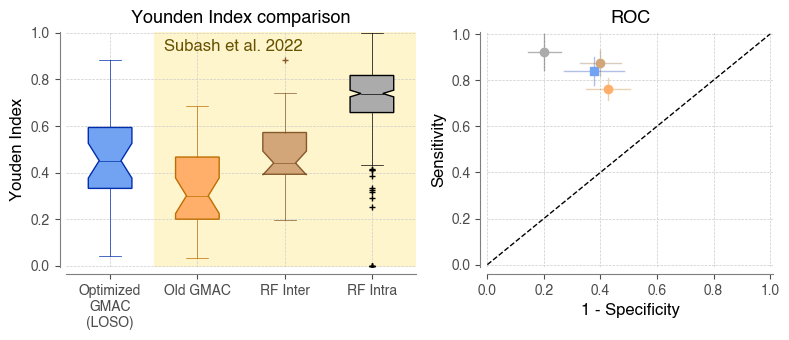

In [47]:
# Combine data from all limbs
lightc = ["#f08181", "#72a3f2", "#ffaf69", "#d2a679", "#ababab", "#b2b266", "#b2b266"]
darkc = ["#a80a0a", "#002eab", "#bd6e00", "#86592d", "black", "#55552b", "#55552b"]
fig = plt.figure(figsize=(8, 3.5))
gs = gridspec.GridSpec(1, 2, height_ratios=[1], width_ratios=[4.4, 3.6])
ax = plt.subplot(gs[0, 0])

# Current performance
j = 1
ax.boxplot(x=losoperf["youden"], positions=[j],
           widths=0.5, notch=True, patch_artist=True,
           boxprops=dict(facecolor=lightc[j], color=darkc[j], alpha=1.0),
           capprops=dict(color=darkc[j], alpha=1.0, lw=0.5),
           whiskerprops=dict(color=darkc[j], alpha=1.0, lw=0.5),
           flierprops=dict(color=darkc[j], markeredgecolor=darkc[j],
                           markerfacecolor=darkc[j], marker='+', markersize=4),
           medianprops=dict(color=darkc[j], alpha=1.0, lw=0.5))

# Previous performance
# GMAC
j = 2
_vals = np.hstack([subash_perf_gmac["youden"][i] for i in range(4)])
ax.boxplot(x=_vals, positions=[j],
           widths=0.5, notch=True, patch_artist=True,
           boxprops=dict(facecolor=lightc[j], color=darkc[j], alpha=1.0),
           capprops=dict(color=darkc[j], alpha=1.0, lw=0.5),
           whiskerprops=dict(color=darkc[j], alpha=1.0, lw=0.5),
           flierprops=dict(color=darkc[j], markeredgecolor=darkc[j],
                           markerfacecolor=darkc[j], marker='+', markersize=4),
           medianprops=dict(color=darkc[j], alpha=1.0, lw=0.5))
# RF INTER
j = 3
_vals = np.hstack([subash_perf_rfinter["youden"][i] for i in range(4)])
ax.boxplot(x=_vals, positions=[j],
           widths=0.5, notch=True, patch_artist=True,
           boxprops=dict(facecolor=lightc[j], color=darkc[j], alpha=1.0),
           capprops=dict(color=darkc[j], alpha=1.0, lw=0.5),
           whiskerprops=dict(color=darkc[j], alpha=1.0, lw=0.5),
           flierprops=dict(color=darkc[j], markeredgecolor=darkc[j],
                           markerfacecolor=darkc[j], marker='+', markersize=4),
           medianprops=dict(color=darkc[j], alpha=1.0, lw=0.5))
# RF INTRA
j = 4
_vals = np.hstack([subash_perf_rfintra["youden"][i] for i in range(4)])
_vals = _vals[~np.isnan(_vals)]
ax.boxplot(x=_vals, positions=[j],
           widths=0.5, notch=True, patch_artist=True,
           boxprops=dict(facecolor=lightc[j], color=darkc[j], alpha=1.0),
           capprops=dict(color=darkc[j], alpha=1.0, lw=0.5),
           whiskerprops=dict(color=darkc[j], alpha=1.0, lw=0.5),
           flierprops=dict(color=darkc[j], markeredgecolor=darkc[j],
                           markerfacecolor=darkc[j], marker='+', markersize=4),
           medianprops=dict(color=darkc[j], alpha=1.0, lw=0.5))
# Backgrounds
background = plt.Rectangle((0.25, 0), 1, 1,
                           transform=ax.transAxes,
                           color='#fff5cc', zorder=-1)
ax.add_patch(background)
ax.text(0.28, 0.97, "Subash et al. 2022", ha="left", va="top", fontsize=12,
        color="#665200", transform=ax.transAxes,)

ax.set_ylim(-0.005, 1.005)
ax.set_xlim(0.5, 4.5)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_position(('outward', 5))
ax.spines['bottom'].set_position(('outward', 5))
ax.spines['left'].set_color("tab:gray")
ax.spines['bottom'].set_color("tab:gray")
ax.tick_params(axis='x', colors='0.3')
ax.tick_params(axis='y', colors='0.3')
ax.grid(color='0.8', linestyle='--', linewidth=0.5);
ax.set_xticklabels(
    ["Optimized\nGMAC\n(LOSO)",] +
    ["Old GMAC", "RF Inter", "RF Intra"],
)
ax.set_ylabel("Youden Index", fontsize=12)
ax.set_title("Younden Index comparison", fontsize=13)

# ROC plot
ax = plt.subplot(gs[0, 1])
ax.plot([0, 1], [0, 1], lw=1, color="black", ls="--")
# LOO Optimized GMAC
_valsens = losoperf["sensitivity"]
_valspec = losoperf["specificity"]
_xmean, _ymean = np.mean(_valspec), np.mean(_valsens)
_xstd, _ystd = np.std(_valspec), np.std(_valsens)
ax.plot([1 - _xmean - 0.5 * _xstd, 1 - _xmean + 0.5 * _xstd],
        [_ymean, _ymean], color=darkc[1], alpha=0.3, lw=1)
ax.plot([1 - _xmean, 1 - _xmean],
        [_ymean - 0.5 * _ystd, _ymean + 0.5 * _ystd], color=darkc[1], alpha=0.3, lw=1)
ax.plot([1 - _xmean], [_ymean], marker="s", ms=6, color=lightc[1], alpha=1)

# Old GMAC
_valsens = np.hstack([subash_perf_gmac["sensitivity"][i] for i in range(4)])
_valspec = np.hstack([subash_perf_gmac["specificity"][i] for i in range(4)])
_xmean, _ymean = np.mean(_valspec), np.mean(_valsens)
_xstd, _ystd = np.std(_valspec), np.std(_valsens)
ax.plot([1 - _xmean - 0.5 * _xstd, 1 - _xmean + 0.5 * _xstd],
        [_ymean, _ymean], color=darkc[2], alpha=0.3, lw=1)
ax.plot([1 - _xmean, 1 - _xmean],
        [_ymean - 0.5 * _ystd, _ymean + 0.5 * _ystd], color=darkc[2], alpha=0.3, lw=1)
ax.plot([1 - _xmean], [_ymean], marker="o", ms=6, color=lightc[2], alpha=1)
# RF Inter
_valsens = np.hstack([subash_perf_rfinter["sensitivity"][i] for i in range(4)])
_valspec = np.hstack([subash_perf_rfinter["specificity"][i] for i in range(4)])
_xmean, _ymean = np.mean(_valspec), np.mean(_valsens)
_xstd, _ystd = np.std(_valspec), np.std(_valsens)
ax.plot([1 - _xmean - 0.5 * _xstd, 1 - _xmean + 0.5 * _xstd],
        [_ymean, _ymean], color=darkc[3], alpha=0.3, lw=1)
ax.plot([1 - _xmean, 1 - _xmean],
        [_ymean - 0.5 * _ystd, _ymean + 0.5 * _ystd], color=darkc[3], alpha=0.3, lw=1)
ax.plot([1 - _xmean], [_ymean], marker="o", ms=6, color=lightc[3], alpha=1)
# RF Intra
_valsens = np.hstack([subash_perf_rfintra["sensitivity"][i] for i in range(4)])
_valspec = np.hstack([subash_perf_rfintra["specificity"][i] for i in range(4)])
_xmean, _ymean = np.nanmean(_valspec), np.nanmean(_valsens)
_xstd, _ystd = np.nanstd(_valspec), np.nanstd(_valsens)
ax.plot([1 - _xmean - 0.5 * _xstd, 1 - _xmean + 0.5 * _xstd],
        [_ymean, _ymean], color=darkc[4], alpha=0.3, lw=1)
ax.plot([1 - _xmean, 1 - _xmean],
        [_ymean - 0.5 * _ystd, _ymean + 0.5 * _ystd], color=darkc[4], alpha=0.3, lw=1)
ax.plot([1 - _xmean], [_ymean], marker="o", ms=6, color=lightc[4], alpha=1)
ax.set_ylim(-0.01, 1.01)
ax.set_xlim(0.0, 1.01)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_position(('outward', 5))
ax.spines['bottom'].set_position(('outward', 5))
ax.spines['left'].set_color("tab:gray")
ax.spines['bottom'].set_color("tab:gray")
ax.tick_params(axis='x', colors='0.3')
ax.tick_params(axis='y', colors='0.3')
ax.grid(color='0.8', linestyle='--', linewidth=0.5);
ax.set_ylabel("Sensitivity", fontsize=12)
ax.set_xlabel("1 - Specificity", fontsize=12)
ax.set_title("ROC", fontsize=13)

plt.tight_layout()

fig.savefig(pathlib.Path(basedir, f"gmac_summary_all_med_loso.pdf"), bbox_inches="tight")
fig.savefig(pathlib.Path(basedir, f"gmac_summary_all_med_loso.svg"), bbox_inches="tight")

### Comparing performance with Subash et al. 2022 (means, CIs)

In [27]:
def compute_bootstrap_mean_ci(rawdata, n_bootstrap_samples=1000):
    # Find the bootstrap means and CIs.
    bootstrap_means = np.zeros(n_bootstrap_samples)
    for i in range(n_bootstrap_samples):
        bootstrap_sample = np.random.choice(rawdata, size=len(rawdata), replace=True)
        bootstrap_means[i] = np.mean(bootstrap_sample)
    return (np.nanmean(bootstrap_means),
            np.nanpercentile(bootstrap_means, [2.5, 97.5]))

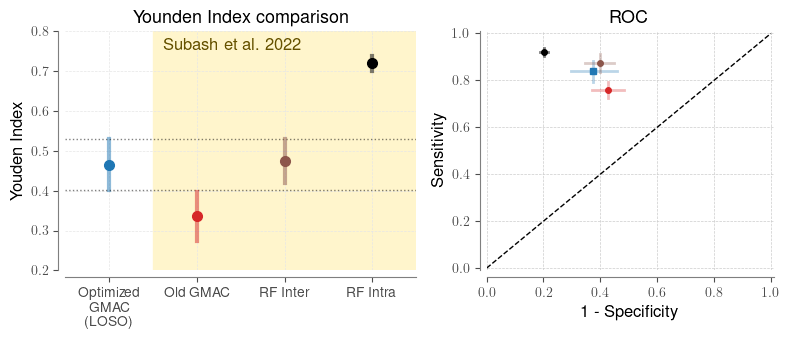

In [28]:
# Combine data from all limbs
lightc = ["#f08181", "#72a3f2", "#ffaf69", "#d2a679", "#ababab", "#b2b266", "#b2b266"]
# darkc = ["#a80a0a", "#002eab", "#bd6e00", "#86592d", "black", "#55552b", "#55552b"]
darkc = ["#a80a0a", "tab:blue", "tab:red", "tab:brown", "black", "#55552b", "#55552b"]
darkc_dict = {f"{i}": c for i, c in enumerate(darkc)}
fig = plt.figure(figsize=(8, 3.5))
gs = gridspec.GridSpec(1, 2, height_ratios=[1], width_ratios=[4.4, 3.6])

# Number of bootstrap samples
means = {}
ci95 = {}
# Find the bootstrap means and CIs.
means["newgmac"], ci95["newgmac"] = compute_bootstrap_mean_ci(losoperfdf[losoperfdf["method"] == "GMAC"]["youden"])
means["oldgmac"], ci95["oldgmac"] = compute_bootstrap_mean_ci(losoperfdf[losoperfdf["method"] == "OldGMAC"]["youden"])
means["rfinter"], ci95["rfinter"] = compute_bootstrap_mean_ci(losoperfdf[losoperfdf["method"] == "RFinter"]["youden"])
means["rfintra"], ci95["rfintra"] = compute_bootstrap_mean_ci(losoperfdf[losoperfdf["method"] == "RFintra"]["youden"])

ax = plt.subplot(gs[0, 0])
# Current performance
j = 1
ax.plot([j-0.], [means["newgmac"]], color=darkc[j], marker="o", markersize=7)
ax.plot([j, j], ci95["newgmac"], color=darkc[j], lw=3, alpha=0.5)
ax.axhline(ci95["newgmac"][0], color="black", alpha=0.5, lw=1, ls="dotted")
ax.axhline(ci95["newgmac"][1], color="black", alpha=0.5, lw=1, ls="dotted")
j = 2
ax.plot([j-0.], [means["oldgmac"]], color=darkc[j], marker="o", markersize=7)
ax.plot([j, j], ci95["oldgmac"], color=darkc[j], lw=3, alpha=0.5)
j = 3
ax.plot([j-0.], [means["rfinter"]], color=darkc[j], marker="o", markersize=7)
ax.plot([j, j], ci95["rfinter"], color=darkc[j], lw=3, alpha=0.5)
j = 4
ax.plot([j-0.], [means["rfintra"]], color=darkc[j], marker="o", markersize=7)
ax.plot([j, j], ci95["rfintra"], color=darkc[j], lw=3, alpha=0.5)

# Backgrounds
background = plt.Rectangle((0.25, 0), 1, 1,
                           transform=ax.transAxes,
                           color='#fff5cc', zorder=-1)
ax.add_patch(background)
ax.text(0.28, 0.97, "Subash et al. 2022", ha="left", va="top", fontsize=12,
        color="#665200", transform=ax.transAxes,)

ax.set_ylim(0.2, 0.8)
ax.set_xlim(0.5, 4.5)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_position(('outward', 5))
ax.spines['bottom'].set_position(('outward', 5))
ax.spines['left'].set_color("tab:gray")
ax.spines['bottom'].set_color("tab:gray")
ax.tick_params(axis='x', colors='0.3')
ax.tick_params(axis='y', colors='0.3')
ax.grid(color='0.9', linestyle='--', linewidth=0.5);
ax.set_xticks([1, 2, 3, 4])
ax.set_xticklabels(
    ["Optimized\nGMAC\n(LOSO)",] +
    ["Old GMAC", "RF Inter", "RF Intra"],
)
ax.set_ylabel("Youden Index", fontsize=12)
ax.set_title("Younden Index comparison", fontsize=13)

# ROC plot
ax = plt.subplot(gs[0, 1])
ax.plot([0, 1], [0, 1], lw=1, color="black", ls="--")
# LOSO Optimized GMAC
_xmean, _xci = compute_bootstrap_mean_ci(losoperfdf[losoperfdf["method"] == "GMAC"]["specificity"])
_ymean, _yci = compute_bootstrap_mean_ci(losoperfdf[losoperfdf["method"] == "GMAC"]["sensitivity"])
ax.plot(1 - _xci, [_ymean, _ymean], color=darkc[1], alpha=0.3, lw=2)
ax.plot([1 - _xmean, 1 - _xmean], _yci, color=darkc[1], alpha=0.3, lw=2)
ax.plot([1 - _xmean], [_ymean], marker="s", ms=4, color=darkc[1], alpha=1)

# Old GMAC
_xmean, _xci = compute_bootstrap_mean_ci(losoperfdf[losoperfdf["method"] == "OldGMAC"]["specificity"])
_ymean, _yci = compute_bootstrap_mean_ci(losoperfdf[losoperfdf["method"] == "OldGMAC"]["sensitivity"])
ax.plot(1 - _xci, [_ymean, _ymean], color=darkc[2], alpha=0.3, lw=2)
ax.plot([1 - _xmean, 1 - _xmean], _yci, color=darkc[2], alpha=0.3, lw=2)
ax.plot([1 - _xmean], [_ymean], marker="o", ms=4, color=darkc[2], alpha=1)

# RF Inter
_xmean, _xci = compute_bootstrap_mean_ci(losoperfdf[losoperfdf["method"] == "RFinter"]["specificity"])
_ymean, _yci = compute_bootstrap_mean_ci(losoperfdf[losoperfdf["method"] == "RFinter"]["sensitivity"])
ax.plot(1 - _xci, [_ymean, _ymean], color=darkc[3], alpha=0.3, lw=2)
ax.plot([1 - _xmean, 1 - _xmean], _yci, color=darkc[3], alpha=0.3, lw=2)
ax.plot([1 - _xmean], [_ymean], marker="o", ms=4, color=darkc[3], alpha=1)

# RF Intra
_xmean, _xci = compute_bootstrap_mean_ci(losoperfdf[losoperfdf["method"] == "RFintra"]["specificity"])
_ymean, _yci = compute_bootstrap_mean_ci(losoperfdf[losoperfdf["method"] == "RFintra"]["sensitivity"])
ax.plot(1 - _xci, [_ymean, _ymean], color=darkc[4], alpha=0.5, lw=2)
ax.plot([1 - _xmean, 1 - _xmean], _yci, color=darkc[4], alpha=0.5, lw=2)
ax.plot([1 - _xmean], [_ymean], marker="o", ms=4, color=darkc[4], alpha=1)

ax.set_ylim(-0.01, 1.01)
ax.set_xlim(0.0, 1.01)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_position(('outward', 5))
ax.spines['bottom'].set_position(('outward', 5))
ax.spines['left'].set_color("tab:gray")
ax.spines['bottom'].set_color("tab:gray")
ax.tick_params(axis='x', colors='0.3')
ax.tick_params(axis='y', colors='0.3')
ax.grid(color='0.8', linestyle='--', linewidth=0.5);
ax.set_ylabel("Sensitivity", fontsize=12)
ax.set_xlabel("1 - Specificity", fontsize=12)
ax.set_title("ROC", fontsize=13)

plt.tight_layout()

fig.savefig(pathlib.Path(basedir, f"gmac_summary_all_loso.pdf"), bbox_inches="tight")
fig.savefig(pathlib.Path(basedir, f"gmac_summary_all_loso.svg"), bbox_inches="tight")

### ROC Plots for GMAC for different parameter combination

In [29]:
import random

In [30]:
# Healthy subject indidces
_subjs = [_s for _s in gmac_perf["subjtype"].unique() if 'H' in _s]
healthy_inx = gmac_perf["subjtype"] == _subjs[0]
for _s in _subjs[1:]:
    healthy_inx = healthy_inx | (gmac_perf["subjtype"] == _s)
_subjs = [_s for _s in gmac_perf["subjtype"].unique() if 'S' in _s]
stroke_inx = gmac_perf["subjtype"] == _subjs[0]
for _s in _subjs[1:]:
    stroke_inx = stroke_inx | (gmac_perf["subjtype"] == _s)

In [32]:
losoperfdf

,subj,subjid,limb,method,youden,sensitivity,specificity
0,H9,9,left,GMAC,0.764873,0.872587,0.892287
1,H9,9,right,GMAC,0.884187,0.929606,0.954581
2,H10,10,left,GMAC,0.323321,0.642773,0.680548
3,H10,10,right,GMAC,0.444087,0.759789,0.684298
4,H2,2,left,GMAC,0.268546,0.866807,0.401739
...,...,...,...,...,...,...,...
415,H5,5,right,RFintra,0.674451,0.982143,0.692308
416,H5,5,right,RFintra,0.730769,0.980769,0.750000
417,H5,5,right,RFintra,0.668750,0.968750,0.700000
418,H5,5,right,RFintra,0.666667,1.000000,0.666667


KeyError: 'type'

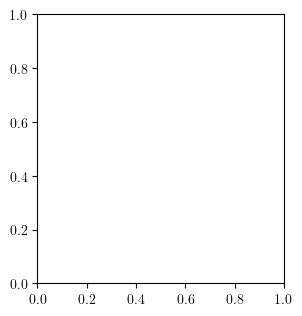

In [31]:
# Figure.
fig = plt.figure(figsize=(7, 3.5))
ax = fig.add_subplot(121)
# Get Sens, and Spec.
# Number of bootstrap samples
means = {}
ci95 = {}

# Find the bootstrap means and CIs.
# Right Limb
_inxhr = ((losoperfdf["type"] == "healthy") &
          (losoperfdf["limb"] == "right"))
_xmean, _xci = compute_bootstrap_mean_ci(losoperfdf[_inxhr]["specificity"].values)
_ymean, _yci = compute_bootstrap_mean_ci(losoperfdf[_inxhr]["sensitivity"].values)
ax.plot(1 - _xci, [_ymean, _ymean], color="tab:red", alpha=1, lw=2)
ax.plot([1 - _xmean, 1 - _xmean], _yci, color="tab:red", alpha=1, lw=2)
ax.plot([1 - _xmean], [_ymean], marker="s", ms=4, color="tab:red", alpha=1)

# spec, sens vals
limb_inx = (gmac_perf["limb"] == "right")
N = np.sum(healthy_inx & limb_inx)
_randinx = np.random.choice(N, 1000, replace=False)
_spec = 1 - gmac_perf[healthy_inx & limb_inx]["specificity"].values
_sens = gmac_perf[healthy_inx & limb_inx]["sensitivity"].values
ax.plot(_spec[_randinx], _sens[_randinx], color="tab:red", marker=".", markersize=3,
        alpha=0.1, linestyle="None")

# Left Limb
_inxhr = ((losoperfdf["type"] == "healthy") &
          (losoperfdf["limb"] == "left"))
_xmean, _xci = compute_bootstrap_mean_ci(losoperfdf[_inxhr]["specificity"].values)
_ymean, _yci = compute_bootstrap_mean_ci(losoperfdf[_inxhr]["sensitivity"].values)
ax.plot(1 - _xci, [_ymean, _ymean], color="tab:blue", alpha=1, lw=2)
ax.plot([1 - _xmean, 1 - _xmean], _yci, color="tab:blue", alpha=1, lw=2)
ax.plot([1 - _xmean], [_ymean], marker="s", ms=4, color="tab:blue", alpha=1)

# spec, sens vals
limb_inx = (gmac_perf["limb"] == "left")
N = np.sum(healthy_inx & limb_inx)
_randinx = np.random.choice(N, 1000, replace=False)
_spec = 1 - gmac_perf[healthy_inx & limb_inx]["specificity"].values
_sens = gmac_perf[healthy_inx & limb_inx]["sensitivity"].values
ax.plot(_spec[_randinx], _sens[_randinx], color="tab:blue", marker=".", markersize=3,
        alpha=0.1, linestyle="None")
# ax.plot([1 - _xmean], [_ymean], marker="s", ms=4, color="tab:blue", alpha=1)

ax.plot([0, 1], [0, 1], lw=1, color="black", ls="--")
ax.set_ylim(-0.01, 1.01)
ax.set_xlim(0.0, 1.01)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_position(('outward', 5))
ax.spines['bottom'].set_position(('outward', 5))
ax.spines['left'].set_color("tab:gray")
ax.spines['bottom'].set_color("tab:gray")
ax.tick_params(axis='x', colors='0.3')
ax.tick_params(axis='y', colors='0.3')
ax.grid(color='0.8', linestyle='--', linewidth=0.5);
ax.set_ylabel("Sensitivity", fontsize=12)
ax.set_xlabel("1 - Specificity", fontsize=12)
ax.set_title("Healthy Subjects", fontsize=13)

ax = fig.add_subplot(122)
# Unaffected Limb
_inxhr = ((losoperfdf["type"] == "stroke") &
          (losoperfdf["limb"] == "unaff"))
_xmean, _xci = compute_bootstrap_mean_ci(losoperfdf[_inxhr]["specificity"].values)
_ymean, _yci = compute_bootstrap_mean_ci(losoperfdf[_inxhr]["sensitivity"].values)
ax.plot(1 - _xci, [_ymean, _ymean], color="tab:red", alpha=1, lw=2)
ax.plot([1 - _xmean, 1 - _xmean], _yci, color="tab:red", alpha=1, lw=2)
ax.plot([1 - _xmean], [_ymean], marker="s", ms=4, color="tab:red", alpha=1)

# spec, sens vals
limb_inx = (gmac_perf["limb"] == "unaff")
N = np.sum(stroke_inx & limb_inx)
_randinx = np.random.choice(N, 1000, replace=False)
_spec = 1 - gmac_perf[stroke_inx & limb_inx]["specificity"].values
_sens = gmac_perf[stroke_inx & limb_inx]["sensitivity"].values
ax.plot(_spec[_randinx], _sens[_randinx], color="tab:red", marker=".", markersize=3,
        alpha=0.1, linestyle="None")

# Left Limb
_inxhr = ((losoperfdf["type"] == "stroke") &
          (losoperfdf["limb"] == "aff"))
_xmean, _xci = compute_bootstrap_mean_ci(losoperfdf[_inxhr]["specificity"].values)
_ymean, _yci = compute_bootstrap_mean_ci(losoperfdf[_inxhr]["sensitivity"].values)
ax.plot(1 - _xci, [_ymean, _ymean], color="tab:blue", alpha=1, lw=2)
ax.plot([1 - _xmean, 1 - _xmean], _yci, color="tab:blue", alpha=1, lw=2)
ax.plot([1 - _xmean], [_ymean], marker="s", ms=4, color="tab:blue", alpha=1)

# spec, sens vals
limb_inx = (gmac_perf["limb"] == "aff")
N = np.sum(stroke_inx & limb_inx)
_randinx = np.random.choice(N, 1000, replace=False)
_spec = 1 - gmac_perf[stroke_inx & limb_inx]["specificity"].values
_sens = gmac_perf[stroke_inx & limb_inx]["sensitivity"].values
ax.plot(_spec[_randinx], _sens[_randinx], color="tab:blue", marker=".", markersize=3,
        alpha=0.1, linestyle="None")
# ax.plot([1 - _xmean], [_ymean], marker="s", ms=4, color="tab:blue", alpha=1)

ax.plot([0, 1], [0, 1], lw=1, color="black", ls="--")
ax.set_ylim(-0.01, 1.01)
ax.set_xlim(0.0, 1.01)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_position(('outward', 5))
ax.spines['bottom'].set_position(('outward', 5))
ax.spines['left'].set_color("tab:gray")
ax.spines['bottom'].set_color("tab:gray")
ax.tick_params(axis='x', colors='0.3')
ax.tick_params(axis='y', colors='0.3')
ax.grid(color='0.8', linestyle='--', linewidth=0.5);
# ax.set_ylabel("Sensitivity", fontsize=12)
ax.set_xlabel("1 - Specificity", fontsize=12)
ax.set_title("Stroke Subjects", fontsize=13)

plt.tight_layout()

fig.savefig(pathlib.Path(basedir, f"ROC_loso.pdf"), bbox_inches="tight")
fig.savefig(pathlib.Path(basedir, f"ROC_loso.svg"), bbox_inches="tight")

## Extra Plots

In [33]:
# subjs = list(set(gmac_perf.subjtype))
# subjsh = list(_s for _s in set(gmac_perf.subjtype) if "H" in _s)
# subjsp = list(_s for _s in set(gmac_perf.subjtype) if "S" in _s)

# # Get the performance of the left out subject for the best parameters.
# def _get_dict(n): 
#     return {"youden": np.zeros(n),
#             "sensitivity": np.zeros(n),
#             "specificity": np.zeros(n)}

# losoperfh = {
#     "left": _get_dict(len(subjsh)),
#     "right": _get_dict(len(subjsh)),
# }
# for i, _subj in enumerate(subjsh):
#     for _l in ["left", "right"]:
#         # Index to leave out.
#         _looinx = ((gmac_perf.subjtype == _subj) &
#                    (gmac_perf.limb == _l))
#         _inx = ((gmac_perf.np == bestargs[i][0]) &
#                 (gmac_perf.fc == bestargs[i][1]) &
#                 (gmac_perf.nc == bestargs[i][2]) &
#                 (gmac_perf.nam == bestargs[i][3]) &
#                 (gmac_perf.p_th == bestargs[i][4]) &
#                 (gmac_perf.p_th_band == bestargs[i][5]) &
#                 (gmac_perf.am_th == bestargs[i][6]) &
#                 (gmac_perf.am_th_band == bestargs[i][7]))
#         # Computer performance
#         losoperfh[_l]["youden"][i] = gmac_perf.loc[_looinx & _inx, "youden"].values[0]
#         losoperfh[_l]["sensitivity"][i] = gmac_perf.loc[_looinx & _inx, "sensitivity"].values[0]
#         losoperfh[_l]["specificity"][i] = gmac_perf.loc[_looinx & _inx, "specificity"].values[0]

# # Get the performance of the left out subject for the best parameters.
# losoperfp = {
#     "aff": _get_dict(len(subjsp)),
#     "unaff": _get_dict(len(subjsp)),
# }
# for i, _subj in enumerate(subjsp):
#     for _l in ["aff", "unaff"]:
#         # Index to leave out.
#         _looinx = ((gmac_perf.subjtype == _subj) &
#                    (gmac_perf.limb == _l))
#         _inx = ((gmac_perf.np == bestargs[i][0]) &
#                 (gmac_perf.fc == bestargs[i][1]) &
#                 (gmac_perf.nc == bestargs[i][2]) &
#                 (gmac_perf.nam == bestargs[i][3]) &
#                 (gmac_perf.p_th == bestargs[i][4]) &
#                 (gmac_perf.p_th_band == bestargs[i][5]) &
#                 (gmac_perf.am_th == bestargs[i][6]) &
#                 (gmac_perf.am_th_band == bestargs[i][7]))
#         # Computer performance
#         losoperfp[_l]["youden"][i] = gmac_perf.loc[_looinx & _inx, "youden"].values[0]
#         losoperfp[_l]["sensitivity"][i] = gmac_perf.loc[_looinx & _inx, "sensitivity"].values[0]
#         losoperfp[_l]["specificity"][i] = gmac_perf.loc[_looinx & _inx, "specificity"].values[0]

KeyError: 0

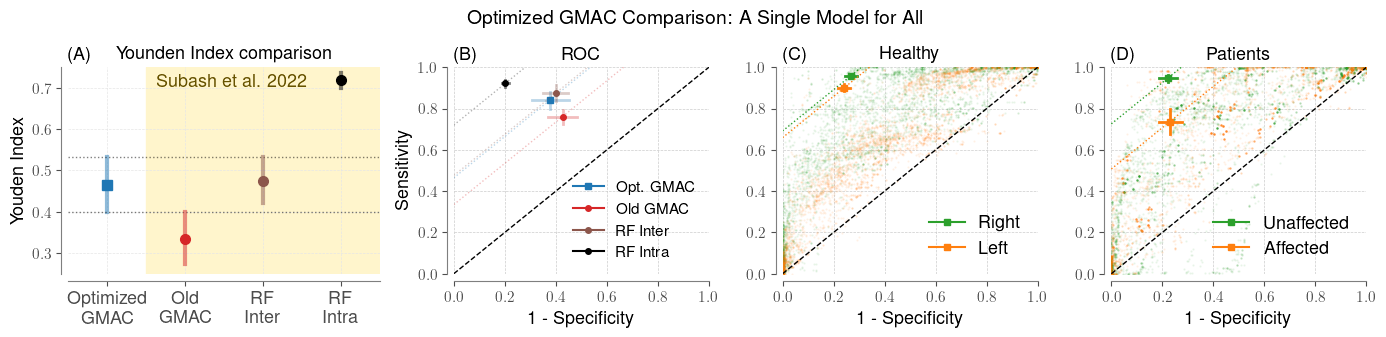

In [211]:
# Combine data from all limbs
lightc = ["#f08181", "#72a3f2", "#ffaf69", "#d2a679", "#ababab", "#b2b266", "#b2b266"]
# darkc = ["#a80a0a", "#002eab", "#bd6e00", "#86592d", "black", "#55552b", "#55552b"]
darkc = ["#a80a0a", "tab:blue", "tab:red", "tab:brown", "black", "#55552b", "#55552b"]
darkc_dict = {f"{i}": c for i, c in enumerate(darkc)}
fig = plt.figure(figsize=(14, 3.5))
gs = gridspec.GridSpec(1, 4, height_ratios=[1], width_ratios=[4.4, 3.6, 3.6, 3.6])

# Number of bootstrap samples
means = {}
ci95 = {}
# Find the bootstrap means and CIs.
means["newgmac"], ci95["newgmac"] = compute_bootstrap_mean_ci(losoperfdf[losoperfdf["method"] == "GMAC"]["youden"])
means["oldgmac"], ci95["oldgmac"] = compute_bootstrap_mean_ci(losoperfdf[losoperfdf["method"] == "OldGMAC"]["youden"])
means["rfinter"], ci95["rfinter"] = compute_bootstrap_mean_ci(losoperfdf[losoperfdf["method"] == "RFinter"]["youden"])
means["rfintra"], ci95["rfintra"] = compute_bootstrap_mean_ci(losoperfdf[losoperfdf["method"] == "RFintra"]["youden"])

ax = plt.subplot(gs[0, 0])
# Current performance
j = 1
ax.plot([j-0.], [means["newgmac"]], color=darkc[j], marker="s", markersize=7)
ax.plot([j, j], ci95["newgmac"], color=darkc[j], lw=3, alpha=0.5)
ax.axhline(ci95["newgmac"][0], color="black", alpha=0.5, lw=1, ls="dotted")
ax.axhline(ci95["newgmac"][1], color="black", alpha=0.5, lw=1, ls="dotted")
j = 2
ax.plot([j-0.], [means["oldgmac"]], color=darkc[j], marker="o", markersize=7)
ax.plot([j, j], ci95["oldgmac"], color=darkc[j], lw=3, alpha=0.5)
j = 3
ax.plot([j-0.], [means["rfinter"]], color=darkc[j], marker="o", markersize=7)
ax.plot([j, j], ci95["rfinter"], color=darkc[j], lw=3, alpha=0.5)
j = 4
ax.plot([j-0.], [means["rfintra"]], color=darkc[j], marker="o", markersize=7)
ax.plot([j, j], ci95["rfintra"], color=darkc[j], lw=3, alpha=0.5)

# Backgrounds
background = plt.Rectangle((0.25, 0), 1, 1,
                           transform=ax.transAxes,
                           color='#fff5cc', zorder=-1)
ax.add_patch(background)
ax.text(0.28, 0.97, "Subash et al. 2022", ha="left", va="top", fontsize=13,
        color="#665200", transform=ax.transAxes,)

# Subfigure label, using not data reference.
ax.text(0, 1.1, "(A)", ha="left", va="top", fontsize=13,
        color="black", transform=ax.transAxes)

ax.set_ylim(0.25, 0.75)
ax.set_xlim(0.5, 4.5)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_position(('outward', 5))
ax.spines['bottom'].set_position(('outward', 5))
ax.spines['left'].set_color("tab:gray")
ax.spines['bottom'].set_color("tab:gray")
ax.tick_params(axis='x', colors='0.3')
ax.tick_params(axis='y', colors='0.3', labelsize=11)
ax.grid(color='0.9', linestyle='--', linewidth=0.5);
ax.set_xticks([1, 2, 3, 4])
ax.set_xticklabels(
    ["Optimized\nGMAC",] +
    ["Old\nGMAC", "RF\nInter", "RF\nIntra"],
    fontsize=13
)
# Set the fontsize of y ticks labels.
ax.set_ylabel("Youden Index", fontsize=13)
ax.set_title("Younden Index comparison", fontsize=13)

# ROC plot
ax = plt.subplot(gs[0, 1])
ax.plot([0, 1], [0, 1], lw=1, color="black", ls="--")
# LOSO Optimized GMAC
_xmean, _xci = compute_bootstrap_mean_ci(losoperfdf[losoperfdf["method"] == "GMAC"]["specificity"])
_ymean, _yci = compute_bootstrap_mean_ci(losoperfdf[losoperfdf["method"] == "GMAC"]["sensitivity"])
ax.plot(1 - _xci, [_ymean, _ymean], color=darkc[1], alpha=0.3, lw=2)
ax.plot([1 - _xmean, 1 - _xmean], _yci, color=darkc[1], alpha=0.3, lw=2)
ax.plot([1 - _xmean], [_ymean], marker="s", ms=4, color=darkc[1], alpha=1, label="Opt. GMAC")
ax.plot([0, 2 - _xmean - _ymean], [-1 + _ymean + _xmean, 1], ls="dotted", lw=1, color=darkc[1], alpha=0.3)

# Old GMAC
_xmean, _xci = compute_bootstrap_mean_ci(losoperfdf[losoperfdf["method"] == "OldGMAC"]["specificity"])
_ymean, _yci = compute_bootstrap_mean_ci(losoperfdf[losoperfdf["method"] == "OldGMAC"]["sensitivity"])
ax.plot(1 - _xci, [_ymean, _ymean], color=darkc[2], alpha=0.3, lw=2)
ax.plot([1 - _xmean, 1 - _xmean], _yci, color=darkc[2], alpha=0.3, lw=2)
ax.plot([1 - _xmean], [_ymean], marker="o", ms=4, color=darkc[2], alpha=1, label="Old GMAC")
ax.plot([0, 2 - _xmean - _ymean], [-1 + _ymean + _xmean, 1], ls="dotted", lw=1, color=darkc[2], alpha=0.3)

# RF Inter
_xmean, _xci = compute_bootstrap_mean_ci(losoperfdf[losoperfdf["method"] == "RFinter"]["specificity"])
_ymean, _yci = compute_bootstrap_mean_ci(losoperfdf[losoperfdf["method"] == "RFinter"]["sensitivity"])
ax.plot(1 - _xci, [_ymean, _ymean], color=darkc[3], alpha=0.3, lw=2)
ax.plot([1 - _xmean, 1 - _xmean], _yci, color=darkc[3], alpha=0.3, lw=2)
ax.plot([1 - _xmean], [_ymean], marker="o", ms=4, color=darkc[3], alpha=1, label="RF Inter")
ax.plot([0, 2 - _xmean - _ymean], [-1 + _ymean + _xmean, 1], ls="dotted", lw=1, color=darkc[3], alpha=0.3)

# RF Intra
_xmean, _xci = compute_bootstrap_mean_ci(losoperfdf[losoperfdf["method"] == "RFintra"]["specificity"])
_ymean, _yci = compute_bootstrap_mean_ci(losoperfdf[losoperfdf["method"] == "RFintra"]["sensitivity"])
ax.plot(1 - _xci, [_ymean, _ymean], color=darkc[4], alpha=0.5, lw=2)
ax.plot([1 - _xmean, 1 - _xmean], _yci, color=darkc[4], alpha=0.5, lw=2)
ax.plot([1 - _xmean], [_ymean], marker="o", ms=4, color=darkc[4], alpha=1, label="RF Intra")
ax.plot([0, 2 - _xmean - _ymean], [-1 + _ymean + _xmean, 1], ls="dotted", lw=1, color=darkc[4], alpha=0.3)

# Subfigure label.
ax.text(0, 1.1, "(B)", ha="left", va="top", fontsize=13,
        color="black", transform=ax.transAxes)
ax.legend(loc=4, frameon=False, fontsize=11)
ax.set_ylim(0.0, 1.00)
ax.set_xlim(0.0, 1.00)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_position(('outward', 5))
ax.spines['bottom'].set_position(('outward', 5))
ax.spines['left'].set_color("tab:gray")
ax.spines['bottom'].set_color("tab:gray")
ax.tick_params(axis='x', colors='0.3', labelsize=11)
ax.tick_params(axis='y', colors='0.3', labelsize=11)
ax.grid(color='0.8', linestyle='--', linewidth=0.5);
ax.set_ylabel("Sensitivity", fontsize=13)
ax.set_xlabel("1 - Specificity", fontsize=13)
ax.set_title("ROC", fontsize=13)

ax = plt.subplot(gs[0, 2])
# Get Sens, and Spec.
# Number of bootstrap samples
means = {}
ci95 = {}

# Find the bootstrap means and CIs.
# Right Limb
_xmean, _xci = compute_bootstrap_mean_ci(losoperfdf[losoperfdf["limb"] == "right"]["specificity"])
_ymean, _yci = compute_bootstrap_mean_ci(losoperfdf[losoperfdf["limb"] == "right"]["sensitivity"])
ax.plot(1 - _xci, [_ymean, _ymean], color="tab:green", alpha=1, lw=2)
ax.plot([1 - _xmean, 1 - _xmean], _yci, color="tab:green", alpha=1, lw=2)
ax.plot([1 - _xmean], [_ymean], marker="s", ms=4, color="tab:green", alpha=1, label="Right")
ax.plot([0, 2 - _xmean - _ymean], [-1 + _ymean + _xmean, 1], ls="dotted", lw=1, color="tab:green", alpha=1)

# spec, sens vals
limb_inx = (gmac_perf["limb"] == "right")
N = np.sum(limb_inx)
_randinx = np.random.choice(N, 5000, replace=False)
_spec = 1 - gmac_perf[limb_inx]["specificity"].values
_sens = gmac_perf[limb_inx]["sensitivity"].values
ax.plot(_spec[_randinx], _sens[_randinx], color="tab:green", marker=".", markersize=1,
        alpha=0.1, linestyle="None")

# Left Limb
_xmean, _xci = compute_bootstrap_mean_ci(losoperfdf[losoperfdf["limb"] == "left"]["specificity"])
_ymean, _yci = compute_bootstrap_mean_ci(losoperfdf[losoperfdf["limb"] == "left"]["sensitivity"])
ax.plot(1 - _xci, [_ymean, _ymean], color="tab:orange", alpha=1, lw=2)
ax.plot([1 - _xmean, 1 - _xmean], _yci, color="tab:orange", alpha=1, lw=2)
ax.plot([1 - _xmean], [_ymean], marker="s", ms=4, color="tab:orange", alpha=1, label="Left")
ax.plot([0, 2 - _xmean - _ymean], [-1 + _ymean + _xmean, 1], ls="dotted", lw=1, color="tab:orange", alpha=1)


# spec, sens vals
limb_inx = (gmac_perf["limb"] == "left")
N = np.sum(limb_inx)
_randinx = np.random.choice(N, 5000, replace=False)
_spec = 1 - gmac_perf[limb_inx]["specificity"].values
_sens = gmac_perf[limb_inx]["sensitivity"].values
ax.plot(_spec[_randinx], _sens[_randinx], color="tab:orange", marker=".", markersize=1,
        alpha=0.1, linestyle="None")

# Subfigure label.
ax.text(0, 1.1, "(C)", ha="left", va="top", fontsize=13,
        color="black", transform=ax.transAxes)

ax.plot([0, 1], [0, 1], lw=1, color="black", ls="--")
ax.set_ylim(0.0, 1.00)
ax.set_xlim(0.0, 1.00)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_position(('outward', 5))
ax.spines['bottom'].set_position(('outward', 5))
ax.spines['left'].set_color("tab:gray")
ax.spines['bottom'].set_color("tab:gray")
ax.tick_params(axis='x', colors='0.3', labelsize=11)
ax.tick_params(axis='y', colors='0.3', labelsize=11)
ax.grid(color='0.8', linestyle='--', linewidth=0.5);
ax.set_xlabel("1 - Specificity", fontsize=13)
ax.legend(loc=4, frameon=False, fontsize=13)
ax.set_title("Healthy", fontsize=13)

ax = plt.subplot(gs[0, 3])
# Unaffected Limb
_xmean, _xci = compute_bootstrap_mean_ci(losoperfdf[losoperfdf["limb"] == "unaff"]["specificity"])
_ymean, _yci = compute_bootstrap_mean_ci(losoperfdf[losoperfdf["limb"] == "unaff"]["sensitivity"])
ax.plot(1 - _xci, [_ymean, _ymean], color="tab:green", alpha=1, lw=2)
ax.plot([1 - _xmean, 1 - _xmean], _yci, color="tab:green", alpha=1, lw=2)
ax.plot([1 - _xmean], [_ymean], marker="s", ms=4, color="tab:green", alpha=1, label="Unaffected")
ax.plot([0, 2 - _xmean - _ymean], [-1 + _ymean + _xmean, 1], ls="dotted", lw=1, color="tab:green", alpha=1)

# spec, sens vals
limb_inx = (gmac_perf["limb"] == "unaff")
N = np.sum( limb_inx)
_randinx = np.random.choice(N, 5000, replace=False)
_spec = 1 - gmac_perf[ limb_inx]["specificity"].values
_sens = gmac_perf[ limb_inx]["sensitivity"].values
ax.plot(_spec[_randinx], _sens[_randinx], color="tab:green", marker=".", markersize=1,
        alpha=0.1, linestyle="None")

# Left Limb
_xmean, _xci = compute_bootstrap_mean_ci(losoperfdf[losoperfdf["limb"] == "aff"]["specificity"])
_ymean, _yci = compute_bootstrap_mean_ci(losoperfdf[losoperfdf["limb"] == "aff"]["sensitivity"])
ax.plot(1 - _xci, [_ymean, _ymean], color="tab:orange", alpha=1, lw=2)
ax.plot([1 - _xmean, 1 - _xmean], _yci, color="tab:orange", alpha=1, lw=2)
ax.plot([1 - _xmean], [_ymean], marker="s", ms=4, color="tab:orange", alpha=1, label="Affected")
ax.plot([0, 2 - _xmean - _ymean], [-1 + _ymean + _xmean, 1], ls="dotted", lw=1, color="tab:orange", alpha=1)

# spec, sens vals
limb_inx = (gmac_perf["limb"] == "aff")
N = np.sum( limb_inx)
_randinx = np.random.choice(N, 5000, replace=False)
_spec = 1 - gmac_perf[ limb_inx]["specificity"].values
_sens = gmac_perf[ limb_inx]["sensitivity"].values
ax.plot(_spec[_randinx], _sens[_randinx], color="tab:orange", marker=".", markersize=1,
        alpha=0.1, linestyle="None")

# Subfigure label.
ax.text(0, 1.1, "(D)", ha="left", va="top", fontsize=13,
        color="black", transform=ax.transAxes)

ax.plot([0, 1], [0, 1], lw=1, color="black", ls="--")
ax.set_ylim(0.0, 1.00)
ax.set_xlim(0.0, 1.00)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_position(('outward', 5))
ax.spines['bottom'].set_position(('outward', 5))
ax.spines['left'].set_color("tab:gray")
ax.spines['bottom'].set_color("tab:gray")
ax.tick_params(axis='x', colors='0.3', labelsize=11)
ax.tick_params(axis='y', colors='0.3', labelsize=11)
ax.grid(color='0.8', linestyle='--', linewidth=0.5);
ax.set_xlabel("1 - Specificity", fontsize=13)
ax.legend(loc=4, frameon=False, fontsize=13)
ax.set_title("Patients", fontsize=13)

plt.suptitle("Optimized GMAC Comparison: A Single Model for All", y=0.95, fontsize=14)
plt.tight_layout()

fig.savefig(pathlib.Path(basedir, f"gmac_summary_all_loso_roc.pdf"), bbox_inches="tight")
fig.savefig(pathlib.Path(basedir, f"gmac_summary_all_loso_roc.svg"), bbox_inches="tight")

### LME model of performance

In [102]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy import stats

#### All subjects

In [180]:
# Methods index
gmacinx = losoperfdf["method"] == "GMAC"
oldgmacinx = losoperfdf["method"] == "OldGMAC"
rfinterinx = losoperfdf["method"] == "RFinter"
rfintrainx = losoperfdf["method"] == "RFintramean"

#### Younden

In [181]:
youdendf = losoperfdf.loc[gmacinx | oldgmacinx | rfinterinx | rfintrainx,
                          ["subj", "limb", "method", "youden"]].reset_index(drop=True)
lme_youden = smf.mixedlm("youden ~ method", data=youdendf, groups=youdendf["subj"])
lme_youden.fit(method='bfgs').summary()

/Users/siva82kb/anaconda3/envs/gmac/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


<class 'statsmodels.iolib.summary2.Summary'>
"""
             Mixed Linear Model Regression Results
================================================================
Model:                 MixedLM    Dependent Variable:    youden 
No. Observations:      120        Method:                REML   
No. Groups:            15         Scale:                 0.0221 
Min. group size:       8          Log-Likelihood:        41.9346
Max. group size:       8          Converged:             Yes    
Mean group size:       8.0                                      
----------------------------------------------------------------
                      Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------------
Intercept              0.463    0.033 13.860 0.000  0.398  0.529
method[T.OldGMAC]     -0.129    0.038 -3.371 0.001 -0.204 -0.054
method[T.RFinter]      0.012    0.038  0.313 0.754 -0.063  0.087
method[T.RFintramean]  0.254    0.038  6.619 0.000  0.179  0.329
Group Var              0.006    0.023                           
================================================================

"""

#### Sensitivity

In [184]:
sensitivitydf = losoperfdf.loc[gmacinx | oldgmacinx | rfinterinx | rfintrainx,
                           ["subj", "limb", "method", "sensitivity"]].reset_index(drop=True)
lme_sensitivity = smf.mixedlm("sensitivity ~ method", data=sensitivitydf, groups=sensitivitydf["subj"])
lme_sensitivity.fit(method='bfgs').summary()

/Users/siva82kb/anaconda3/envs/gmac/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


<class 'statsmodels.iolib.summary2.Summary'>
"""
             Mixed Linear Model Regression Results
================================================================
Model:               MixedLM   Dependent Variable:   sensitivity
No. Observations:    120       Method:               REML       
No. Groups:          15        Scale:                0.0150     
Min. group size:     8         Log-Likelihood:       72.2027    
Max. group size:     8         Converged:            Yes        
Mean group size:     8.0                                        
----------------------------------------------------------------
                      Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------------
Intercept              0.839    0.022 37.542 0.000  0.796  0.883
method[T.OldGMAC]     -0.079    0.032 -2.495 0.013 -0.141 -0.017
method[T.RFinter]      0.035    0.032  1.122 0.262 -0.026  0.097
method[T.RFintramean]  0.080    0.032  2.519 0.012  0.018  0.142
Group Var              0.000    0.006                           
================================================================

"""

#### Specificity

In [185]:
specificitydf = losoperfdf.loc[gmacinx | oldgmacinx | rfinterinx | rfintrainx,
                           ["subj", "limb", "method", "specificity"]].reset_index(drop=True)
lme_specificity = smf.mixedlm("specificity ~ method", data=specificitydf, groups=specificitydf["subj"])
lme_specificity.fit(method='bfgs').summary()

/Users/siva82kb/anaconda3/envs/gmac/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


<class 'statsmodels.iolib.summary2.Summary'>
"""
             Mixed Linear Model Regression Results
================================================================
Model:               MixedLM   Dependent Variable:   specificity
No. Observations:    120       Method:               REML       
No. Groups:          15        Scale:                0.0203     
Min. group size:     8         Log-Likelihood:       46.7636    
Max. group size:     8         Converged:            Yes        
Mean group size:     8.0                                        
----------------------------------------------------------------
                      Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------------
Intercept              0.624    0.032 19.520 0.000  0.561  0.686
method[T.OldGMAC]     -0.050    0.037 -1.369 0.171 -0.123  0.022
method[T.RFinter]     -0.023    0.037 -0.638 0.524 -0.096  0.049
method[T.RFintramean]  0.174    0.037  4.733 0.000  0.102  0.246
Group Var              0.005    0.022                           
================================================================

"""

### Healthy/Patients

In [265]:
# Healthy index
# Index of all subj column values which have a 'H' at the start.
subjsh = list(_s for _s in set(losoperfdf.subj) if "H" in _s)
# Get the logical index variable for the subj column that are in subjsh
subj_inx = losoperfdf["subj"] == subjsh[0]
for _s in subjsh[1:]:
    subj_inx = subj_inx | (losoperfdf["subj"] == _s)

#### Younden

In [266]:
youdendf = losoperfdf.loc[subj_inx & (gmacinx | oldgmacinx | rfinterinx | rfintrainx),
                          ["subj", "limb", "method", "youden"]].reset_index(drop=True)
lme_youden = smf.mixedlm("youden ~ method", data=youdendf, groups=youdendf["subj"])
lme_youden.fit(method='bfgs').summary()

/Users/siva82kb/anaconda3/envs/gmac/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


<class 'statsmodels.iolib.summary2.Summary'>
"""
             Mixed Linear Model Regression Results
================================================================
Model:                 MixedLM    Dependent Variable:    youden 
No. Observations:      80         Method:                REML   
No. Groups:            10         Scale:                 0.0130 
Min. group size:       8          Log-Likelihood:        42.8326
Max. group size:       8          Converged:             Yes    
Mean group size:       8.0                                      
----------------------------------------------------------------
                      Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------------
Intercept              0.502    0.039 12.778 0.000  0.425  0.579
method[T.OldGMAC]     -0.192    0.036 -5.337 0.000 -0.263 -0.122
method[T.RFinter]      0.005    0.036  0.130 0.897 -0.066  0.075
method[T.RFintramean]  0.238    0.036  6.610 0.000  0.168  0.309
Group Var              0.009    0.046                           
================================================================

"""

#### Sensitivity

In [267]:
sensitivitydf = losoperfdf.loc[subj_inx & (gmacinx | oldgmacinx | rfinterinx | rfintrainx),
                               ["subj", "limb", "method", "sensitivity"]].reset_index(drop=True)
lme_sensitivity = smf.mixedlm("sensitivity ~ method", data=sensitivitydf, groups=sensitivitydf["subj"])
lme_sensitivity.fit(method='bfgs').summary()

/Users/siva82kb/anaconda3/envs/gmac/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


<class 'statsmodels.iolib.summary2.Summary'>
"""
             Mixed Linear Model Regression Results
================================================================
Model:               MixedLM   Dependent Variable:   sensitivity
No. Observations:    80        Method:               REML       
No. Groups:          10        Scale:                0.0077     
Min. group size:     8         Log-Likelihood:       70.8529    
Max. group size:     8         Converged:            Yes        
Mean group size:     8.0                                        
----------------------------------------------------------------
                      Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------------
Intercept              0.812    0.020 41.149 0.000  0.774  0.851
method[T.OldGMAC]     -0.071    0.028 -2.556 0.011 -0.125 -0.017
method[T.RFinter]      0.092    0.028  3.319 0.001  0.038  0.147
method[T.RFintramean]  0.148    0.028  5.339 0.000  0.094  0.203
Group Var              0.000    0.006                           
================================================================

"""

#### Specificity

In [268]:
specificitydf = losoperfdf.loc[subj_inx & (gmacinx | oldgmacinx | rfinterinx | rfintrainx),
                               ["subj", "limb", "method", "specificity"]].reset_index(drop=True)
lme_specificity = smf.mixedlm("specificity ~ method", data=specificitydf, groups=specificitydf["subj"])
lme_specificity.fit(method='bfgs').summary()

/Users/siva82kb/anaconda3/envs/gmac/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


<class 'statsmodels.iolib.summary2.Summary'>
"""
             Mixed Linear Model Regression Results
================================================================
Model:               MixedLM   Dependent Variable:   specificity
No. Observations:    80        Method:               REML       
No. Groups:          10        Scale:                0.0104     
Min. group size:     8         Log-Likelihood:       50.5967    
Max. group size:     8         Converged:            Yes        
Mean group size:     8.0                                        
----------------------------------------------------------------
                      Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------------
Intercept              0.689    0.037 18.732 0.000  0.617  0.762
method[T.OldGMAC]     -0.121    0.032 -3.758 0.000 -0.185 -0.058
method[T.RFinter]     -0.088    0.032 -2.711 0.007 -0.151 -0.024
method[T.RFintramean]  0.090    0.032  2.784 0.005  0.027  0.153
Group Var              0.008    0.047                           
================================================================

"""

### Limbwise differences

In [269]:
youdendf = losoperfdf.loc[subj_inx & (gmacinx),
                          ["subj", "limb", "method", "youden"]].reset_index(drop=True)
lme_youden = smf.mixedlm("youden ~ limb", data=youdendf, groups=youdendf["subj"])
lme_youden.fit(method='bfgs').summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
        Mixed Linear Model Regression Results
======================================================
Model:             MixedLM Dependent Variable: youden 
No. Observations:  20      Method:             REML   
No. Groups:        10      Scale:              0.0047 
Min. group size:   2       Log-Likelihood:     10.8585
Max. group size:   2       Converged:          Yes    
Mean group size:   2.0                                
------------------------------------------------------
              Coef. Std.Err.   z   P>|z| [0.025 0.975]
------------------------------------------------------
Intercept     0.408    0.047 8.684 0.000  0.316  0.500
limb[T.right] 0.188    0.031 6.143 0.000  0.128  0.248
Group Var     0.017    0.192                          
======================================================

"""

## GMAC Compare

In [274]:
gmac_compare = pd.read_csv(pathlib.Path(basedir, "gmac_compare.csv"))
gmac_compare["LimbCode"] = 0
gmac_compare.loc[gmac_compare["Limb"] == "Right", "LimbCode"] = 1
gmac_compare.loc[gmac_compare["Limb"] == "Unaff", "LimbCode"] = 1
gmac_compare

,Limb,Subject,Method,youden,LimbCode
0,Right,H1,m-all,0.594234,1
1,Right,H2,m-all,0.405791,1
2,Right,H3,m-all,0.767236,1
3,Right,H4,m-all,0.700170,1
4,Right,H5,m-all,0.638580,1
5,Right,H6,m-all,0.458231,1
6,Right,H7,m-all,0.469653,1
7,Right,H8,m-all,0.592651,1
8,Right,H9,m-all,0.884187,1
9,Right,H10,m-all,0.444087,1


In [284]:
# Healthy index
# Index of all subj column values which have a 'H' at the start.
subjsh = list(_s for _s in set(gmac_compare.Subject) if "H" in _s)
# Get the logical index variable for the subj column that are in subjsh
subj_inx = gmac_compare["Subject"] == subjsh[0]
for _s in subjsh[1:]:
    subj_inx = subj_inx | (gmac_compare["Subject"] == _s)

In [285]:
youdendf = gmac_compare.loc[subj_inx, ["Subject", "LimbCode", "Method", "youden"]].reset_index(drop=True)
lme_youden = smf.mixedlm("youden ~ Method + LimbCode + Method * LimbCode", data=youdendf, groups=youdendf["Subject"])
lme_youden.fit(method='bfgs').summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
               Mixed Linear Model Regression Results
====================================================================
Model:                 MixedLM      Dependent Variable:      youden 
No. Observations:      40           Method:                  REML   
No. Groups:            10           Scale:                   0.0069 
Min. group size:       4            Log-Likelihood:          25.0438
Max. group size:       4            Converged:               Yes    
Mean group size:       4.0                                          
--------------------------------------------------------------------
                          Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------------------
Intercept                  0.408    0.042  9.797 0.000  0.326  0.489
Method[T.m-limb]           0.064    0.037  1.722 0.085 -0.009  0.137
LimbCode                   0.188    0.037  5.040 0.000  0.115  0.261
Method[T.m-limb]:LimbCode -0.122    0.053 -2.314 0.021 -0.225 -0.019
Group Var                  0.010    0.079                           
====================================================================

"""

In [168]:
# stype = "Healthy"
# limbinx = ((losoperfdf["limb"] == "right") |
#            (losoperfdf["limb"] == "left"))
stype = "Patients"
limbinx= ((losoperfdf["limb"] == "unaff") |
          (losoperfdf["limb"] == "aff"))

In [170]:
losoperfdf[limbinx & gmacinx][outcome]

6     0.545639
7     0.464514
12    0.220118
13    0.650902
22    0.636497
23    0.227269
24    0.149497
25    0.503323
26    0.042349
27    0.419932
Name: youden, dtype: float64

In [173]:
losoperfdf[limbinx & gmacinx]

,subj,subjid,limb,method,youden,sensitivity,specificity
6,S4,4,aff,GMAC,0.545639,0.949324,0.596315
7,S4,4,unaff,GMAC,0.464514,0.922351,0.542164
12,S2,2,aff,GMAC,0.220118,0.801845,0.418272
13,S2,2,unaff,GMAC,0.650902,0.789519,0.861383
22,S5,5,aff,GMAC,0.636497,1.000000,0.636497
23,S5,5,unaff,GMAC,0.227269,0.919453,0.307816
24,S1,1,aff,GMAC,0.149497,0.895654,0.253843
25,S1,1,unaff,GMAC,0.503323,0.724368,0.778954
26,S3,3,aff,GMAC,0.042349,0.985487,0.056862
27,S3,3,unaff,GMAC,0.419932,0.947471,0.472461


In [174]:
losoperfdf[limbinx & oldgmacinx]

,subj,subjid,limb,method,youden,sensitivity,specificity
108,S4,4,aff,OldGMAC,0.259829,0.748201,0.511628
121,S4,4,unaff,OldGMAC,0.687375,0.930233,0.757143
186,S2,2,aff,OldGMAC,0.101004,0.905882,0.195122
199,S2,2,unaff,OldGMAC,0.461753,0.784830,0.676923
316,S5,5,aff,OldGMAC,0.468564,0.722222,0.746341
329,S5,5,unaff,OldGMAC,0.510975,0.689922,0.821053
342,S1,1,aff,OldGMAC,0.232040,0.919540,0.312500
355,S1,1,unaff,OldGMAC,0.644383,0.868263,0.776119
368,S3,3,aff,OldGMAC,0.032581,0.593985,0.438596
381,S3,3,unaff,OldGMAC,0.428332,0.825279,0.603053


In [175]:
outcome = "youden"
print(stype)

# GMAC vs. Old GMAC
# Statistical comparison: Perform paired t-tests
t_stat, p_val = stats.ttest_rel(
    losoperfdf[limbinx & gmacinx][outcome].values,
    losoperfdf[limbinx & oldgmacinx][outcome].values
)

# Apply a multiple comparisons correction method (e.g., Bonferroni)
alpha = 0.05 / 3
print(f"[Old GMAC], {outcome}")
if p_val < alpha:
    print(f"{p_val:0.3f}")
else:
    print("Not significant")

_diff = (losoperfdf[limbinx & gmacinx][outcome].values
         - losoperfdf[limbinx & oldgmacinx][outcome].values)
print(f"{np.mean(_diff):0.3f} $\\pm$ {np.std(_diff):0.3f}")

# GMAC vs. Rf inter
# Statistical comparison: Perform paired t-tests
t_stat, p_val = stats.ttest_rel(
    losoperfdf[limbinx & gmacinx][outcome].values,
    losoperfdf[limbinx & rfinterinx][outcome].values
)

# Apply a multiple comparisons correction method (e.g., Bonferroni)
print(f"\n[RF inter], {outcome}")
if p_val < alpha:
    print(f"{p_val:0.3f}")
else:
    print("Not significant")

_diff = (losoperfdf[limbinx & gmacinx][outcome].values
         - losoperfdf[limbinx & rfinterinx][outcome].values)
print(f"{np.mean(_diff):0.3f} $\\pm$ {np.std(_diff):0.3f}")

# GMAC vs. Rf intra
# Statistical comparison: Perform paired t-tests
t_stat, p_val = stats.ttest_rel(
    losoperfdf[limbinx & gmacinx][outcome].values,
    losoperfdf[limbinx & rfintrainx][outcome].values
)

# Apply a multiple comparisons correction method (e.g., Bonferroni)
print(f"\n[RF intra], {outcome}")
if p_val < alpha:
    print(f"{p_val:0.3f}")
else:
    print("Not significant")

_diff = (losoperfdf[limbinx & gmacinx][outcome].values
         - losoperfdf[limbinx & rfintrainx][outcome].values)
print(f"{np.mean(_diff):0.3f} $\\pm$ {np.std(_diff):0.3f}")

Patients
[Old GMAC], youden
Not significant
0.003 $\pm$ 0.178

[RF inter], youden
Not significant
-0.027 $\pm$ 0.175

[RF intra], youden
0.013
-0.285 $\pm$ 0.277


In [65]:
outcome = "sensitivity"
print(stype)

# GMAC vs. Old GMAC
# Statistical comparison: Perform paired t-tests
t_stat, p_val = stats.ttest_rel(
    losoperfdf[limbinx & gmacinx][outcome].values,
    losoperfdf[limbinx & oldgmacinx][outcome].values
)

# Apply a multiple comparisons correction method (e.g., Bonferroni)
alpha = 0.05 / 3
print(f"[Old GMAC], {outcome}")
if p_val < alpha:
    print(f"{p_val:0.3f}")
else:
    print("Not significant")

_diff = (losoperfdf[limbinx & gmacinx][outcome].values
         - losoperfdf[limbinx & oldgmacinx][outcome].values)
print(f"{np.mean(_diff):0.3f} $\\pm$ {np.std(_diff):0.3f}")

# GMAC vs. Rf inter
# Statistical comparison: Perform paired t-tests
t_stat, p_val = stats.ttest_rel(
    losoperfdf[limbinx & gmacinx][outcome].values,
    losoperfdf[limbinx & rfinterinx][outcome].values
)

# Apply a multiple comparisons correction method (e.g., Bonferroni)
print(f"\n[RF inter], {outcome}")
if p_val < alpha:
    print(f"{p_val:0.3f}")
else:
    print("Not significant")

_diff = (losoperfdf[limbinx & gmacinx][outcome].values
         - losoperfdf[limbinx & rfinterinx][outcome].values)
print(f"{np.mean(_diff):0.3f} $\\pm$ {np.std(_diff):0.3f}")

# GMAC vs. Rf intra
# Statistical comparison: Perform paired t-tests
t_stat, p_val = stats.ttest_rel(
    losoperfdf[limbinx & gmacinx][outcome].values,
    losoperfdf[limbinx & rfintrainx][outcome].values
)

# Apply a multiple comparisons correction method (e.g., Bonferroni)
print(f"\n[RF intra], {outcome}")
if p_val < alpha:
    print(f"{p_val:0.3f}")
else:
    print("Not significant")

_diff = (losoperfdf[limbinx & gmacinx][outcome].values
         - losoperfdf[limbinx & rfintrainx][outcome].values)
print(f"{np.mean(_diff):0.3f} $\\pm$ {np.std(_diff):0.3f}")

Patients
[Old GMAC], sensitivity
Not significant
0.148 $\pm$ 0.185

[RF inter], sensitivity
Not significant
0.194 $\pm$ 0.135

[RF intra], sensitivity
Not significant
0.223 $\pm$ 0.296


In [66]:
outcome = "specificity"
print(stype)

# GMAC vs. Old GMAC
# Statistical comparison: Perform paired t-tests
t_stat, p_val = stats.ttest_rel(
    losoperfdf[limbinx & gmacinx][outcome].values,
    losoperfdf[limbinx & oldgmacinx][outcome].values
)

# Apply a multiple comparisons correction method (e.g., Bonferroni)
alpha = 0.05 / 3
print(f"[Old GMAC], {outcome}")
if p_val < alpha:
    print(f"{p_val:0.3f}")
else:
    print("Not significant")

_diff = (losoperfdf[limbinx & gmacinx][outcome].values
         - losoperfdf[limbinx & oldgmacinx][outcome].values)
print(f"{np.mean(_diff):0.3f} $\\pm$ {np.std(_diff):0.3f}")

# GMAC vs. Rf inter
# Statistical comparison: Perform paired t-tests
t_stat, p_val = stats.ttest_rel(
    losoperfdf[limbinx & gmacinx][outcome].values,
    losoperfdf[limbinx & rfinterinx][outcome].values
)

# Apply a multiple comparisons correction method (e.g., Bonferroni)
print(f"\n[RF inter], {outcome}")
if p_val < alpha:
    print(f"{p_val:0.3f}")
else:
    print("Not significant")

_diff = (losoperfdf[limbinx & gmacinx][outcome].values
         - losoperfdf[limbinx & rfinterinx][outcome].values)
print(f"{np.mean(_diff):0.3f} $\\pm$ {np.std(_diff):0.3f}")

# GMAC vs. Rf intra
# Statistical comparison: Perform paired t-tests
t_stat, p_val = stats.ttest_rel(
    losoperfdf[limbinx & gmacinx][outcome].values,
    losoperfdf[limbinx & rfintrainx][outcome].values
)

# Apply a multiple comparisons correction method (e.g., Bonferroni)
print(f"\n[RF intra], {outcome}")
if p_val < alpha:
    print(f"{p_val:0.3f}")
else:
    print("Not significant")

_diff = (losoperfdf[limbinx & gmacinx][outcome].values
         - losoperfdf[limbinx & rfintrainx][outcome].values)
print(f"{np.mean(_diff):0.3f} $\\pm$ {np.std(_diff):0.3f}")

Patients
[Old GMAC], specificity
Not significant
-0.048 $\pm$ 0.203

[RF inter], specificity
Not significant
-0.248 $\pm$ 0.164

[RF intra], specificity
0.004
-0.456 $\pm$ 0.153


In [ ]:
outcome = "youden"
print(stype)

# GMAC vs. Old GMAC
# Statistical comparison: Perform paired t-tests
t_stat, p_val = stats.ttest_rel(
    losoperfdf[limbinx & gmacinx][outcome].values,
    losoperfdf[limbinx & oldgmacinx][outcome].values
)

# Apply a multiple comparisons correction method (e.g., Bonferroni)
alpha = 0.05 / 3
print(f"[Old GMAC], {outcome}")
if p_val < alpha:
    print(f"{p_val:0.3f}")
else:
    print("Not significant")

_diff = (losoperfdf[limbinx & gmacinx][outcome].values
         - losoperfdf[limbinx & oldgmacinx][outcome].values)
print(f"{np.mean(_diff):0.3f} $\\pm$ {np.std(_diff):0.3f}")

# GMAC vs. Rf inter
# Statistical comparison: Perform paired t-tests
t_stat, p_val = stats.ttest_rel(
    losoperfdf[limbinx & gmacinx][outcome].values,
    losoperfdf[limbinx & rfinterinx][outcome].values
)

# Apply a multiple comparisons correction method (e.g., Bonferroni)
print(f"\n[RF inter], {outcome}")
if p_val < alpha:
    print(f"{p_val:0.3f}")
else:
    print("Not significant")

_diff = (losoperfdf[limbinx & gmacinx][outcome].values
         - losoperfdf[limbinx & rfinterinx][outcome].values)
print(f"{np.mean(_diff):0.3f} $\\pm$ {np.std(_diff):0.3f}")

# GMAC vs. Rf intra
# Statistical comparison: Perform paired t-tests
t_stat, p_val = stats.ttest_rel(
    losoperfdf[limbinx & gmacinx][outcome].values,
    losoperfdf[limbinx & rfintrainx][outcome].values
)

# Apply a multiple comparisons correction method (e.g., Bonferroni)
print(f"\n[RF intra], {outcome}")
if p_val < alpha:
    print(f"{p_val:0.3f}")
else:
    print("Not significant")

_diff = (losoperfdf[limbinx & gmacinx][outcome].values
         - losoperfdf[limbinx & rfintrainx][outcome].values)
print(f"{np.mean(_diff):0.3f} $\\pm$ {np.std(_diff):0.3f}")

Patients
[Old GMAC], youden
0.006
0.196 $\pm$ 0.073

[RF inter], youden
Not significant
0.042 $\pm$ 0.165

[RF intra], youden
Not significant
-0.136 $\pm$ 0.328


In [139]:
# subjinx = [f"H{i}" for i in range(1, 11, 1)]
subjinx = [f"S{i}" for i in range(1, 6, 1)]
subj_type = "Healthy" if subjinx[0][0] == "H" else "Patient"

In [145]:
outcome = "youden"

# Print healthy or patient
print(subj_type)

# GMAC vs. Old GMAC
# Statistical comparison: Perform paired t-tests
t_stat, p_val = stats.ttest_rel(combdf.loc[(subjinx,),f"{outcome}_GMAC"], combdf.loc[(subjinx,),f"{outcome}_Old GMAC"])

# Apply a multiple comparisons correction method (e.g., Bonferroni)
alpha = 0.05 / 3
print(f"[Old GMAC], {outcome}")
if p_val < alpha:
    print(f"{p_val:0.3f}")
else:
    print("Not significant")

_diff = combdf.loc[(subjinx,),f"{outcome}_GMAC"] - combdf.loc[(subjinx,),f"{outcome}_Old GMAC"]
print(f"{np.mean(_diff):0.3f} $\\pm$ {np.std(_diff):0.3f}")

# GMAC vs. Rf inter
# Statistical comparison: Perform paired t-tests
t_stat, p_val = stats.ttest_rel(combdf.loc[(subjinx,),f"{outcome}_GMAC"], combdf.loc[(subjinx,),f"{outcome}_RF inter"])

# Apply a multiple comparisons correction method (e.g., Bonferroni)
print(f"\n[RF inter], {outcome}")
if p_val < alpha:
    print(f"{p_val:0.3f}")
else:
    print("Not significant")

_diff = combdf.loc[(subjinx,),f"{outcome}_GMAC"] - combdf.loc[(subjinx,),f"{outcome}_RF inter"]
print(f"{np.mean(_diff):0.3f} $\\pm$ {np.std(_diff):0.3f}")

# GMAC vs. Rf intra
# Statistical comparison: Perform paired t-tests
t_stat, p_val = stats.ttest_rel(combdf.loc[(subjinx,),f"{outcome}_GMAC"], combdf.loc[(subjinx,),f"{outcome}_RF intra"])

# Apply a multiple comparisons correction method (e.g., Bonferroni)
print(f"\n[RF intra], {outcome}")
if p_val < alpha:
    print(f"{p_val:0.3f}")
else:
    print("Not significant")

_diff = combdf.loc[(subjinx,),f"{outcome}_GMAC"] - combdf.loc[(subjinx,),f"{outcome}_RF intra"]
print(f"{np.mean(_diff):0.3f} $\\pm$ {np.std(_diff):0.3f}")

Patient
[Old GMAC], youden
Not significant
0.060 $\pm$ 0.210

[RF inter], youden
Not significant
0.030 $\pm$ 0.143

[RF intra], youden
Not significant
-0.228 $\pm$ 0.246


In [146]:
outcome = "sensitivity"

# Print healthy or patient
print(subj_type)

# GMAC vs. Old GMAC
# Statistical comparison: Perform paired t-tests
t_stat, p_val = stats.ttest_rel(combdf.loc[(subjinx,),f"{outcome}_GMAC"], combdf.loc[(subjinx,),f"{outcome}_Old GMAC"])

# Apply a multiple comparisons correction method (e.g., Bonferroni)
alpha = 0.05 / 3
print(f"[Old GMAC], {outcome}")
if p_val < alpha:
    print(f"{p_val:0.3f}")
else:
    print("Not significant")

_diff = combdf.loc[(subjinx,),f"{outcome}_GMAC"] - combdf.loc[(subjinx,),f"{outcome}_Old GMAC"]
print(f"{np.mean(_diff):0.3f} $\\pm$ {np.std(_diff):0.3f}")

# GMAC vs. Rf inter
# Statistical comparison: Perform paired t-tests
t_stat, p_val = stats.ttest_rel(combdf.loc[(subjinx,),f"{outcome}_GMAC"], combdf.loc[(subjinx,),f"{outcome}_RF inter"])

# Apply a multiple comparisons correction method (e.g., Bonferroni)
print(f"\n[RF inter], {outcome}")
if p_val < alpha:
    print(f"{p_val:0.3f}")
else:
    print("Not significant")

_diff = combdf.loc[(subjinx,),f"{outcome}_GMAC"] - combdf.loc[(subjinx,),f"{outcome}_RF inter"]
print(f"{np.mean(_diff):0.3f} $\\pm$ {np.std(_diff):0.3f}")

# GMAC vs. Rf intra
# Statistical comparison: Perform paired t-tests
t_stat, p_val = stats.ttest_rel(combdf.loc[(subjinx,),f"{outcome}_GMAC"], combdf.loc[(subjinx,),f"{outcome}_RF intra"])

# Apply a multiple comparisons correction method (e.g., Bonferroni)
print(f"\n[RF intra], {outcome}")
if p_val < alpha:
    print(f"{p_val:0.3f}")
else:
    print("Not significant")

_diff = combdf.loc[(subjinx,),f"{outcome}_GMAC"] - combdf.loc[(subjinx,),f"{outcome}_RF intra"]
print(f"{np.mean(_diff):0.3f} $\\pm$ {np.std(_diff):0.3f}")

Patient
[Old GMAC], sensitivity
Not significant
0.054 $\pm$ 0.142

[RF inter], sensitivity
Not significant
0.037 $\pm$ 0.187

[RF intra], sensitivity
Not significant
0.017 $\pm$ 0.296


In [147]:
outcome = "specificity"

# Print healthy or patient
print(subj_type)

# GMAC vs. Old GMAC
# Statistical comparison: Perform paired t-tests
t_stat, p_val = stats.ttest_rel(combdf.loc[(subjinx,),f"{outcome}_GMAC"], combdf.loc[(subjinx,),f"{outcome}_Old GMAC"])

# Apply a multiple comparisons correction method (e.g., Bonferroni)
alpha = 0.05 / 3
print(f"[Old GMAC], {outcome}")
if p_val < alpha:
    print(f"{p_val:0.3f}")
else:
    print("Not significant")

_diff = combdf.loc[(subjinx,),f"{outcome}_GMAC"] - combdf.loc[(subjinx,),f"{outcome}_Old GMAC"]
print(f"{np.mean(_diff):0.3f} $\\pm$ {np.std(_diff):0.3f}")

# GMAC vs. Rf inter
# Statistical comparison: Perform paired t-tests
t_stat, p_val = stats.ttest_rel(combdf.loc[(subjinx,),f"{outcome}_GMAC"], combdf.loc[(subjinx,),f"{outcome}_RF inter"])

# Apply a multiple comparisons correction method (e.g., Bonferroni)
print(f"\n[RF inter], {outcome}")
if p_val < alpha:
    print(f"{p_val:0.3f}")
else:
    print("Not significant")

_diff = combdf.loc[(subjinx,),f"{outcome}_GMAC"] - combdf.loc[(subjinx,),f"{outcome}_RF inter"]
print(f"{np.mean(_diff):0.3f} $\\pm$ {np.std(_diff):0.3f}")

# GMAC vs. Rf intra
# Statistical comparison: Perform paired t-tests
t_stat, p_val = stats.ttest_rel(combdf.loc[(subjinx,),f"{outcome}_GMAC"], combdf.loc[(subjinx,),f"{outcome}_RF intra"])

# Apply a multiple comparisons correction method (e.g., Bonferroni)
print(f"\n[RF intra], {outcome}")
if p_val < alpha:
    print(f"{p_val:0.3f}")
else:
    print("Not significant")

_diff = combdf.loc[(subjinx,),f"{outcome}_GMAC"] - combdf.loc[(subjinx,),f"{outcome}_RF intra"]
print(f"{np.mean(_diff):0.3f} $\\pm$ {np.std(_diff):0.3f}")

Patient
[Old GMAC], specificity
Not significant
0.006 $\pm$ 0.231

[RF inter], specificity
Not significant
-0.007 $\pm$ 0.209

[RF intra], specificity
0.005
-0.245 $\pm$ 0.199
